<a href="https://colab.research.google.com/github/friedameissner/BA/blob/main/NMF_Aldrich.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Uni/BA

/content/drive/My Drive/Uni/BA


In [ ]:
%cd /content/

/content


In [3]:
import numpy as np
import scipy.io as sio
from scipy.cluster.hierarchy import cophenet, linkage, dendrogram, fcluster
from scipy.stats import entropy
#from scipy.special import kl_div, rel_entr
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF, MiniBatchNMF, PCA
from sklearn.model_selection import train_test_split #, validation_curve, KFold
from sklearn.metrics import explained_variance_score
from sklearn.cluster import KMeans, SpectralCoclustering, SpectralBiclustering
from sklearn.manifold import TSNE
import statistics as stat
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools as it
#from utils import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
from skimage import exposure

## NMF

In [4]:
s_opt = 29

In [5]:
def kl_divergence(data, target="W", n_comp=s_opt, n_iter=250, name_mat=None):
    if target == "W":
        name_mat = "W{}".format(n_comp)
        W_list = np.empty((n_iter, data.shape[0], n_comp))

    elif target == "H":
        name_mat = "H{}".format(n_comp)
        W_list = np.empty((n_iter, n_comp, data.shape[1]))

    else:
        raise Exception("Target must be either \"W\" or \"H\".")

    for i in range(n_iter):
        model = NMF(n_components=n_comp, init=None, solver='cd', beta_loss='frobenius', tol=1e-4,
                    max_iter=200, random_state=None, alpha_W=0.01, alpha_H='same', l1_ratio=0.1,
                    verbose=0, shuffle=False)

        if target == "W":
            model.fit(data.T)
            W_list[i,:,:] = model.components_.T

        else:
            W_list[i,:,:] = model.fit_transform(data.T).T # actually H_list

    W_list[W_list == 0] = 1e-8 # ln(0) -> ln(1e-8)

    kl_div = np.empty((n_iter,n_iter))  # pairwise KL div
    mean_kl = np.empty((n_iter))

    for i in range(n_iter):
        for j in range(n_iter):
            kl_div[i,j] = np.sum(entropy(W_list[i,:,:], W_list[j,:,:], axis=1)) # entropy: normalizes cols
        mean_kl[i] = np.mean(kl_div[i,:])
    W_opt = W_list[np.argmin(mean_kl),:,:]

    sio.savemat("{}.mat".format(name_mat), dict(W_opt=W_opt))

    return W_opt


In [6]:
def consensusCluster(data, target="W", n_comp=s_opt, n_iter=250, name_mat="M", plot=True):
    config = dict(n_components=n_comp, init='random', solver='cd', beta_loss='frobenius', tol=0.0001,
                max_iter=200, random_state=None, alpha_W=0.01, alpha_H='same', l1_ratio=0.1,
                verbose=0, shuffle=False)

    if target == "W":
        M = np.zeros((data.shape[0],data.shape[0])) # consensus matrix

    elif target == "H":
        M = np.zeros((data.shape[1],data.shape[1])) # consensus matrix

    else:
        raise Exception("Target must be either \"W\" or \"H\".")

    for k in range(n_iter):
        model = NMF(**config)

        if target == "W":
            model.fit(data.T)
            Wk = model.components_.T # 1 col =^ 1 cluster -> n_comp clusters

        else:
            Wk = model.fit_transform(data.T) # Wk = Hk

        # keeping max value of all cols per row -> each descriptor belongs to one cluster at most
        Wk *= (Wk == Wk.max(axis=1, keepdims=True)) # meta-descriptors

        # cluster comparison -> M: connectivity matrix
        for i in range(n_comp):
            indices = np.where(Wk[:,i] > 0)[0] # 1-dim array (len = num of descriptors in this cluster)
            rows, cols = np.reshape(np.meshgrid(indices, indices), (2,len(indices)**2)) # flattened
            M[np.ix_(rows, cols)] += 1 # marks all descriptors belonging to i-th cluster

    np.fill_diagonal(M, 0)
    M /= n_iter # average of all M

    if name_mat != None:
        sio.savemat("{}.mat".format(name_mat), dict(M=M))

    if plot:
        colorbar(plt.matshow(M, cmap="Greys"))
        plt.show()

    return M


In [7]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    return fig.colorbar(mappable, cax=cax)

### Dravnieks

#### behavior_1

In [ ]:
# Dravnieks
data = np.genfromtxt("behavior_1.csv", delimiter=',', skip_header=1, usecols=range(1,147))
sio.savemat('data_drav.mat', dict(data=data))

#W_init =
#H_init =
error_drav = list()
s_max = 51

for s_opt in range(1,s_max):
    model = NMF(n_components=s_opt, init='random', solver='cd', beta_loss='frobenius', tol=0.0001, max_iter=1000, random_state=None,
            alpha_W=0.1, alpha_H='same', l1_ratio=1.0, verbose=0, shuffle=False)
    H = model.fit_transform(X=data).T # sklearn: exchange of W & H
    #H = model.fit_transform(X=data, W=H_init.T, H=W_init.T).T # sklearn: exchange of W & H
    W_opt = model.components_.T
    error_drav.append(model.reconstruction_err_)

plt.plot(list(range(1,s_max)), error_drav)
plt.xlabel('s')
plt.ylabel('reconstruction error')
plt.show()

#### behavior_2

In [ ]:
data = np.genfromtxt("behavior_2.csv", delimiter=',', skip_header=1, usecols=range(1,147)).T # 146 descriptors x 160 odors

In [ ]:
# Dravnieks
data = np.genfromtxt("behavior_2.csv", delimiter=',', skip_header=1, usecols=range(1,147)).T # 146 descriptors x 160 odors
#sio.savemat('data_drav.mat', dict(data=data))

#W_init =
#H_init =
error_drav = list()
s_max = 51

for s_opt in range(1,s_max):
    model = NMF(n_components=s_opt, init='random', solver='cd', beta_loss='frobenius',
                tol=0.0001, max_iter=200, random_state=None, alpha_W=0.001,
                alpha_H='same', l1_ratio=0.5, verbose=0, shuffle=False)
    H = model.fit_transform(X=data.T).T # sklearn: exchange of W & H
    #H = model.fit_transform(X=data, W=H_init.T, H=W_init.T).T # sklearn: exchange of W & H
    W_opt = model.components_.T
    error_drav.append(model.reconstruction_err_/np.sqrt(data.shape[0]*data.shape[1]))

plt.plot(list(range(1,s_max)), error_drav)
plt.xlabel('s')
plt.ylabel('reconstruction error')
plt.show()

In [ ]:
# NMF + CV
error_cv_drav = np.empty((2,20,250))

config = dict(n_components=None, init=None, solver='cd', beta_loss='frobenius', tol=0.0001,
              max_iter=200, random_state=None, alpha_W=0.01, alpha_H='same', l1_ratio=0.1,
              verbose=0, shuffle=False)

for s in range(10,30):
    config["n_components"] = s

    for i in range(250):
        data_train, data_test = train_test_split(data.T, test_size=0.5, random_state=0) # dim: 80 x 146

        model_train = NMF(**config)
        model_train.fit_transform(data_train)
        error_cv_drav[0,s-10,i] = model_train.reconstruction_err_

        model_test = NMF(**config)
        model_test.fit_transform(data_test)
        error_cv_drav[1,s-10,i] = model_test.reconstruction_err_

#print(error_cv_drav)
sio.savemat('error_cv_drav.mat', dict(error_drav=error_cv_drav))

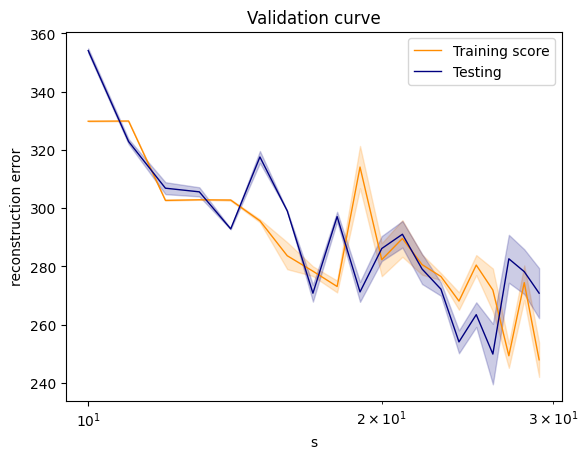

In [ ]:
# Visualization CV
mean_sd_drav = np.empty((2,2,20))

for i in range(20):
    mean_sd_drav[0,0,i] = np.mean(error_cv_drav[0,i,:]) # training
    mean_sd_drav[1,0,i] = np.mean(error_cv_drav[1,i,:]) # test

    mean_sd_drav[0,1,i] = np.std(error_cv_drav[0,i,:]) # training
    mean_sd_drav[1,1,i] = np.std(error_cv_drav[1,i,:]) # test

plt.title("Validation curve")
plt.xlabel('s')
plt.ylabel('reconstruction error')
param_range = range(10,30)

lw = 1
plt.semilogx(param_range, mean_sd_drav[0,0,:], label="Training score", color="darkorange", lw=lw)
plt.fill_between(param_range,
    mean_sd_drav[0,0,:] - mean_sd_drav[0,1,:],
    mean_sd_drav[0,0,:] + mean_sd_drav[0,1,:],
    alpha=0.2,
    color="darkorange",
    lw=lw)

plt.semilogx(param_range, mean_sd_drav[1,0,:], label="Testing", color="navy", lw=lw)
plt.fill_between(param_range,
    mean_sd_drav[1,0,:] - mean_sd_drav[1,1,:],
    mean_sd_drav[1,0,:] + mean_sd_drav[1,1,:],
    alpha=0.2,
    color="navy",
    lw=lw)

plt.legend(loc="best")
plt.show()

In [ ]:
# s_opt = 29 = 19 + 10 (start of range: 10 -> index + 10)
print(min(abs(mean_sd_drav[0,0,:])))
print(np.argmin(abs(mean_sd_drav[0,0,:])))
#print(error_cv_drav[0,19,:])

247.94427514048064
19


In [ ]:
# KL divergence -> most stable W
s_opt = 29

W_opt_drav = kl_divergence(data=data, n_comp=s_opt, n_iter=250, name_mat="W_list_drav")


In [ ]:
W_drav = sio.loadmat("W_list_drav.mat", simplify_cells=True)["W_list"]

In [ ]:
# NMF on scrambled odor profiles
# 1: odorants: columns per row
data_rand_cols = np.copy(data)
# 2: descriptors: rows per column
data_rand_rows = np.copy(data)
# 3: 1 & 2
data_rand_compl = np.copy(data)

for i in range(146):
    data_rand_cols[i,:] = np.random.permutation(data_rand_cols[i,:])
    data_rand_compl[i,:] = np.random.permutation(data_rand_compl[i,:])

for j in range(160):
    data_rand_rows[:,j] = np.random.permutation(data_rand_rows[:,j])
    data_rand_compl[:,j] = np.random.permutation(data_rand_compl[:,j])

# NMF
config = dict(n_components=s_opt, init=None, solver='cd', beta_loss='frobenius',
              tol=0.0001, max_iter=1000, random_state=None, alpha_W=0.1, alpha_H='same',
              l1_ratio=1.0, verbose=0, shuffle=False)

model_rand_cols = NMF(**config)
H_rand_cols = model_rand_cols.fit_transform(data_rand_cols.T).T
W_rand_cols = model_rand_cols.components_.T

model_rand_rows = NMF(**config)
H_rand_rows = model_rand_rows.fit_transform(data_rand_rows.T).T
W_rand_rows = model_rand_rows.components_.T

model_rand_compl = NMF(**config)
H_rand_compl = model_rand_compl.fit_transform(data_rand_compl.T).T
W_rand_compl = model_rand_compl.components_.T

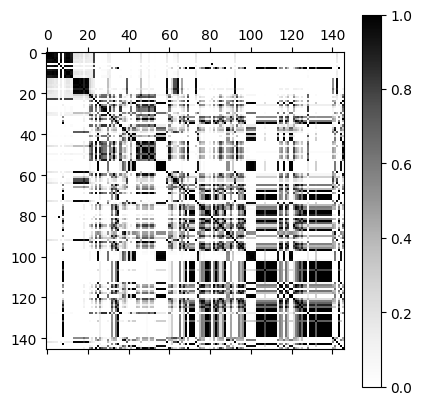

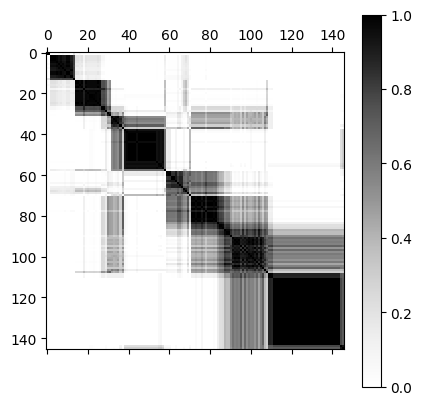

In [ ]:
# Consensus matrix
C_W = consensusCluster(data=data, target="W", n_comp=s_opt, n_iter=100, name_mat="C_W_original", plot=True)

# average linkage HC
C_W_triu = C_W[np.triu_indices(data.shape[0], k=1)]
Z = linkage(y=np.ones_like(C_W_triu)-C_W_triu, method='average', metric='euclidean', optimal_ordering=True)
#fig = plt.figure(figsize=(20, 10))
#dn = dendrogram(Z)
#plt.show()

HC_C = np.argsort(fcluster(Z, t=s_opt, criterion='maxclust'))
C_W_reord = C_W[HC_C][:,HC_C] # reordered consensus matrix according to HC
plt.colorbar(plt.matshow(C_W_reord, cmap="Greys"))
plt.show()

In [ ]:
# Cophenetic correlation coefficient
# distances matrices: np.ones_like(C_W)-C_W;
Z1 = linkage(y=C_W_reord[np.triu_indices(data.shape[0], k=1)], method='average', metric='euclidean', optimal_ordering=True)
coph_W, _ = cophenet(Z1, np.ones_like(C_W_triu)-C_W_triu)
print(coph_W)

# TO DO:
# reason for negative coph -> coph calculation
# plot of coph vs s -> choosing s_opt

-0.05026106253252716


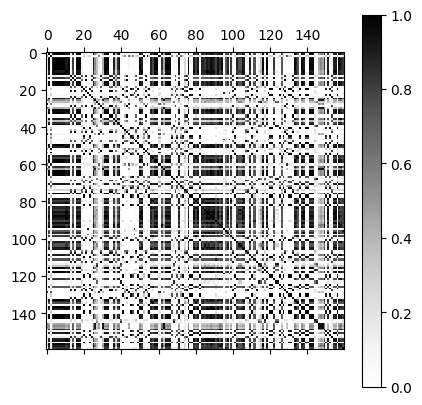

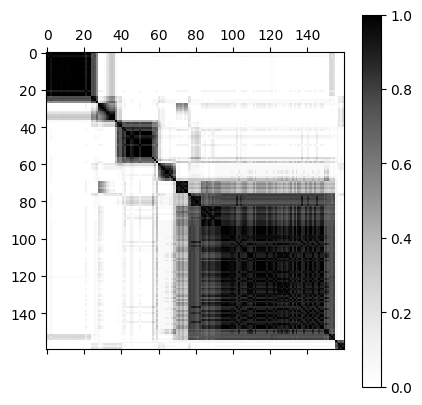

0.04502792611822409


In [ ]:
# Consensus clustering + cophenetic coefficient for H
# Consensus matrix
C_H = consensusCluster(data=data, target="H", n_comp=s_opt, n_iter=100, name_mat="C_H_original", plot=True)

# average linkage HC
C_H_triu = C_H[np.triu_indices(data.shape[1], k=1)]
Z = linkage(y=np.ones_like(C_H_triu)-C_H_triu, method='average', metric='euclidean', optimal_ordering=True)
#fig = plt.figure(figsize=(20, 10))
#dn = dendrogram(Z)
#plt.show()

HC_C = np.argsort(fcluster(Z, t=s_opt, criterion='maxclust'))
C_H_reord = C_H[HC_C][:,HC_C] # reordered consensus matrix according to HC
plt.colorbar(plt.matshow(C_H_reord, cmap="Greys"))
plt.show()

# Cophenetic correlation coefficient
# distances matrices: np.ones_like(C_H)-C_H;
Z1 = linkage(y=C_H_reord[np.triu_indices(data.shape[1], k=1)], method='average', metric='euclidean', optimal_ordering=True)
coph_H, _ = cophenet(Z1, np.ones_like(C_H_triu)-C_H_triu)
print(coph_H)

# TO DO:
# reason for negative coph -> coph calculation
# plot of coph vs s -> choosing s_opt

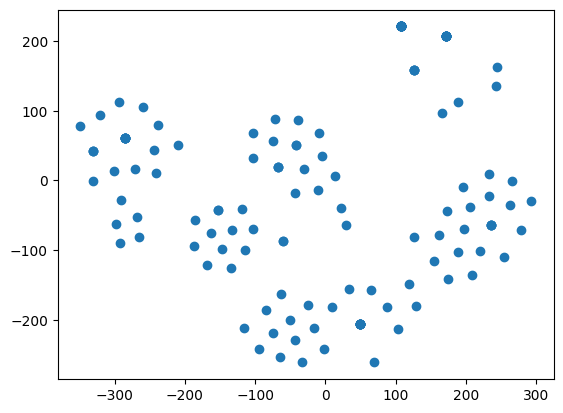

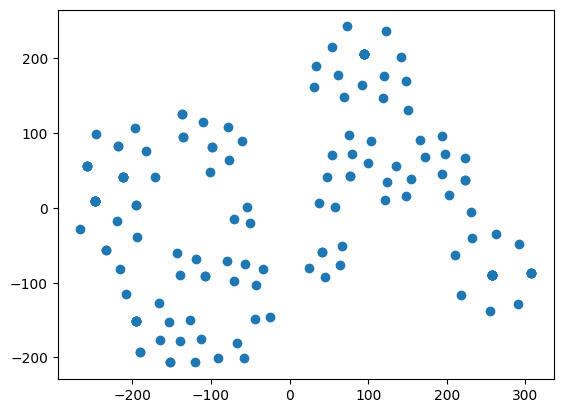

In [ ]:
# Visualization (default parameters)
W_embedded = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate='auto',
              n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean',
              metric_params=None, init='pca', verbose=0, random_state=None, method='barnes_hut',
              angle=0.5, n_jobs=None).fit_transform(C_W_reord)

H_embedded = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate='auto',
              n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean',
              metric_params=None, init='pca', verbose=0, random_state=None, method='barnes_hut',
              angle=0.5, n_jobs=None).fit_transform(C_H_reord)

plt.scatter(W_embedded[:,0], W_embedded[:,1])
plt.show()

plt.scatter(H_embedded[:,0], H_embedded[:,1])
plt.show()

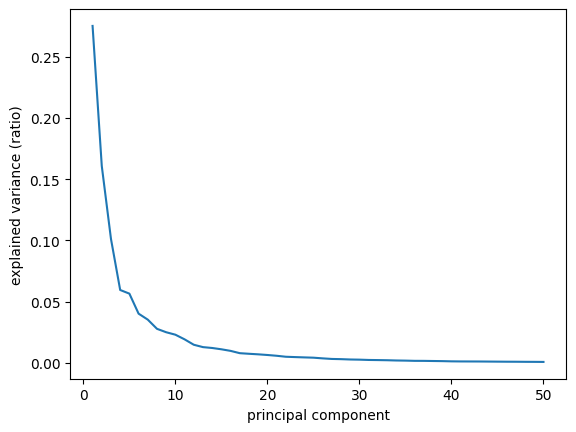

[0.27525997 0.16085289 0.10124705 0.0595639  0.0565855  0.04024036
 0.03534003 0.02784117 0.0250477  0.02303767 0.01923717 0.01482668
 0.01289479 0.01218666 0.01111949 0.00982362 0.00794063 0.00745488
 0.007007   0.00646643 0.00583222 0.00502742 0.00475354 0.00450465
 0.00426849 0.00370919 0.00323689 0.00306885 0.00279295 0.0026573
 0.00241098 0.00230995 0.00218515 0.00198102 0.00186831 0.00168468
 0.00166427 0.00155466 0.00145685 0.00128024 0.00120467 0.00117863
 0.00115555 0.00109717 0.00103591 0.00097986 0.0009531  0.00089299
 0.00085891 0.00080628]


In [ ]:
# PCA(?)
for s_opt in range(1,51):
    model = PCA(n_components=s_opt, copy=True, whiten=False, svd_solver='auto',
                tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto',
                random_state=None)
    model.fit(data)

plt.xlabel("principal component")
plt.ylabel("explained variance (ratio)")
plt.plot(list(range(1,51)), model.explained_variance_ratio_)
plt.show()
print(model.explained_variance_ratio_)

### Sigma-Aldrich

In [8]:
gdb = sio.loadmat("gdb.mat")
odorkey = sio.loadmat("odorkey.mat", simplify_cells = True)

gdb_id = gdb["gdb_id"]
gdb_fema = gdb["gdb_fema"]		# FEMA number (US)
gdb_name = gdb["gdb_name"]
gdb_name = np.array([gdb_name[i][0][0] for i in range(gdb_name.shape[0])])
gdb_formula = gdb["gdb_formula"]
gdb_cas = gdb["gdb_cas"]		# CAS number (international)
gdb_D = gdb["gdb_D"]			# 850x9 matrix

#print(gdb_D[22,:])
#print(np.argwhere(gdb_D[22,:] == 20)[0,0])

odorkey_id = np.concatenate((np.zeros((1)), odorkey["odorkey"][0]))
odorkey_str = np.concatenate((np.empty((1), dtype='str'), odorkey["odorkey"][1])) # 278 descriptors (kept original indices)

In [9]:
V = np.zeros((278,850)) # 278 descriptors x 850 odors
for i in range(278):
	for j in range(850):
		if i+1 in gdb_D[j,:]:
			#V[i,j] = 1
			#V[i,j] = 9 - np.argwhere(gdb_D[j,:] == i+1)[0,0] # value = descriptor priority (1st to last named = 9 to 1)
			#V[i,j] = 1/np.count_nonzero(gdb_D[j,:]) # value = 1/(number of non-zero descriptors) -> unweighted
			#V[i,j] = 1/np.count_nonzero(gdb_D[j,:])/(1+np.argwhere(gdb_D[j,:] == i+1)[0,0]) # value = 1/(number of non-zero descriptors)*(1/priority (1 to 9))
			V[i,j] = np.sqrt(100/np.count_nonzero(gdb_D[j,:])*100*(9 - (np.argwhere(gdb_D[j,:] == i+1)[0,0]))/9) # Castro: percentages of frequency and score (score = priority 9 to 1)
sio.savemat('V.mat', dict(V=V))

### Test

In [ ]:
# Test
error = list()
s_max = 52

for s_opt in range(1,s_max,5):
    model = NMF(n_components=s_opt, init='random', solver='cd', beta_loss='frobenius',
                tol=0.0001, max_iter=200, random_state=None, alpha_W=0.01, alpha_H='same',
                l1_ratio=0.1, verbose=0, shuffle=False)
    H = model.fit_transform(X=V.T).T # sklearn: exchange of W & H
    #H = model.fit_transform(X=V.T, W=H_init.T, H=W_init.T).T # sklearn: exchange of W & H
    W_opt = model.components_.T
    error.append(model.reconstruction_err_/np.sqrt(V.shape[0]*V.shape[1]))

plt.plot(list(range(1,s_max,5)), error)
plt.xlabel('s')
plt.ylabel('reconstruction error')
plt.savefig("200 iter, alpha = 0.01, l1_ratio=0.1.png")

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


### Cross-validation

In [ ]:
# NMF + CV
error_cv = np.empty((2,50,250))

config = dict(n_components=None, init=None, solver='cd', beta_loss='frobenius',
              tol=0.0001, max_iter=200, random_state=None, alpha_W=0.01, alpha_H='same',
              l1_ratio=0.1, verbose=0, shuffle=False)

for s in range(1,51):
    config["n_components"] = s
    model = NMF(**config)

    for i in range(250):
        V_train, V_test = train_test_split(V.T, test_size=0.5, random_state=0) # dim: 425 x 278

        H_train = model.fit_transform(V_train).T
        W = model.components_.T
        error_cv[0,s-1,i] = np.linalg.norm(V_train.T - (W@H_train))

        H_test = model.transform(V_test).T
        error_cv[1,s-1,i] = np.linalg.norm(V_test.T - (W@H_test))

print(error_cv)
sio.savemat('error_cv_50.mat', dict(error=error_cv))

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

[[[1834.5301612  1834.53016129 1834.5301612  ... 1834.53016129
   1834.5301612  1834.5301612 ]
  [1770.61840193 1770.61840193 1770.61840019 ... 1770.61840193
   1770.61840193 1770.61840013]
  [1733.98163415 1733.98163393 1733.981634   ... 1733.98163095
   1733.98163096 1733.981634  ]
  ...
  [1381.01934292 1387.25844239 1391.20243093 ... 1386.80477249
   1381.01633648 1400.56535217]
  [1401.84026493 1380.7553792  1383.32514938 ... 1386.8018913
   1363.63182417 1386.62706354]
  [1381.01281215 1364.00931361 1365.8543733  ... 1346.58670245
   1363.98269642 1363.49865619]]

 [[1835.20029168 1835.2002916  1835.20029168 ... 1835.2002916
   1835.20029168 1835.20029168]
  [1773.19051697 1773.19051697 1773.1905198  ... 1773.19051697
   1773.19051697 1773.1905199 ]
  [1733.0175719  1733.01757197 1733.01757197 ... 1733.01757478
   1733.01757478 1733.01757197]
  ...
  [1417.43751761 1410.12062888 1418.04825081 ... 1414.74105272
   1417.41411056 1443.27045403]
  [1441.30668091 1428.73300816 1429.49

In [ ]:
error_cv = sio.loadmat("error_cv_50.mat", simplify_cells=True)["error"]
#print(np.where(np.isinf(error_cv)))
#print(np.where(np.isnan(error_cv)))

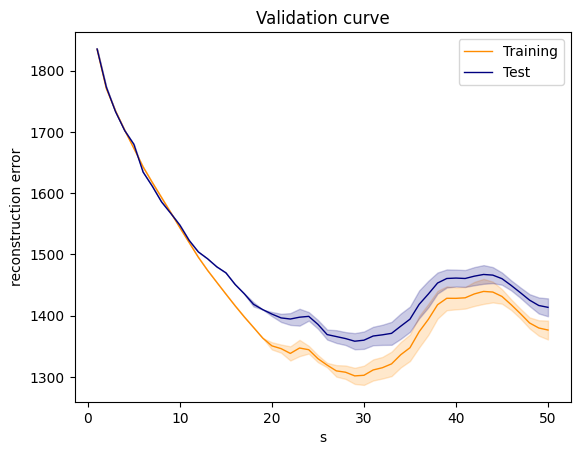

In [ ]:
# Visualization CV
mean_sd = np.empty((2,2,50))

for i in range(50):
    mean_sd[0,0,i] = np.mean(error_cv[0,i,:]) # training
    mean_sd[1,0,i] = np.mean(error_cv[1,i,:]) # test

    mean_sd[0,1,i] = np.std(error_cv[0,i,:]) # training
    mean_sd[1,1,i] = np.std(error_cv[1,i,:]) # test

plt.title("Validation curve")
plt.xlabel('s')
plt.ylabel('reconstruction error')
param_range = range(1,51)

plt.plot(param_range, mean_sd[0,0,:], label="Training", color="darkorange", lw=1)
plt.fill_between(param_range,
    mean_sd[0,0,:] - mean_sd[0,1,:],
    mean_sd[0,0,:] + mean_sd[0,1,:],
    alpha=0.2,
    color="darkorange",
    lw=1)

plt.plot(param_range, mean_sd[1,0,:], label="Test", color="navy", lw=1)
plt.fill_between(param_range,
    mean_sd[1,0,:] - mean_sd[1,1,:],
    mean_sd[1,0,:] + mean_sd[1,1,:],
    alpha=0.2,
    color="navy",
    lw=1)

plt.legend(loc="best")
plt.savefig("Validation 250 splits, iter=200, alpha=0.01, l1_ratio=0.1.png")
plt.show()

In [ ]:
# s_opt = 29 = 28 + 1 (start of range: 1 -> index + 1)
print(min(abs(mean_sd[0,0,:])))
print(np.argmin(abs(mean_sd[0,0,:])))
#print(error_cv[0,19,:])

1301.9303766339167
28


#### Validation Curve (scikit)

In [ ]:
# NMF + CV via Validation Curve, but missing scoring object for NMF
param_range = range(10,61)
cv = KFold(n_splits=2)
train_scores, test_scores = validation_curve(
    estimator=NMF(), X=V.T, y=None, param_name='n_components', param_range=param_range, cv=cv, scoring=NMF().reconstruction_err_)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve")
plt.xlabel('s')
plt.ylabel('error')

lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

# TO DO: scoring object suitable for NMF()

AttributeError: ignored

### KL divergence

In [ ]:
s_opt

10

In [ ]:
# KL divergence -> most stable W
W_opt = kl_divergence(data=V, target="W", n_comp=29, n_iter=250)

In [ ]:
W_opt = sio.loadmat("W29.mat")["W_opt"]

In [ ]:
# KL divergence -> most stable H
H_opt = kl_divergence(data=V, target="H", n_comp=29, n_iter=250)

In [ ]:
H_opt = sio.loadmat("H29.mat")["H_opt"]

### Consensus matrix

In [ ]:
s_opt = 10

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

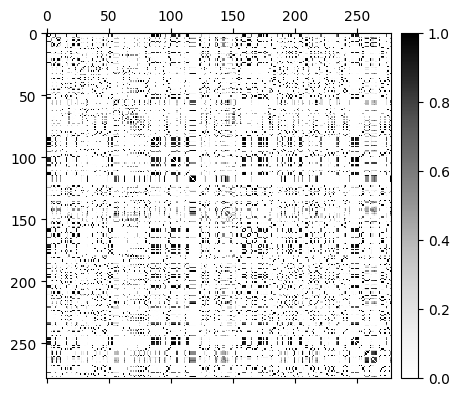

In [ ]:
M = consensusCluster(data=V, target="W", n_comp=s_opt, n_iter=250, name_mat="M_original", plot=True)

In [10]:
M = sio.loadmat("M_original.mat")["M"]
#colorbar(plt.matshow(M, cmap="Greys"))
#plt.show()

### Hierarchical clustering

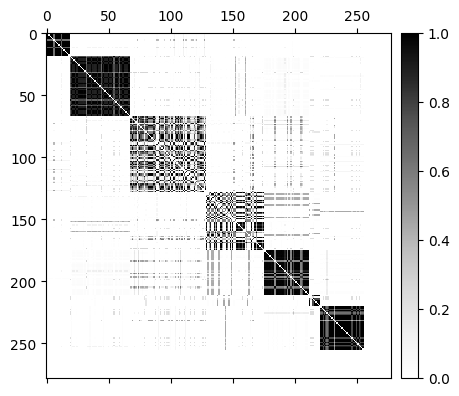

In [11]:
# average linkage HC
Z = linkage(y=1-M[np.triu_indices(V.shape[0], k=1)],
            method='average', metric='euclidean', optimal_ordering=True)
#fig = plt.figure(figsize=(20, 10))
#dn = dendrogram(Z)
#plt.show()

HC_M = np.argsort(fcluster(Z, t=s_opt, criterion='maxclust'))
M_reord = M[HC_M][:,HC_M] # reordered consensus matrix according to HC
colorbar(plt.matshow(M_reord, cmap="Greys"))
plt.show()

### Cophenetic correlation coefficient

In [ ]:
# Cophenetic correlation coefficient
# distance matrices (Brunet et al.)
# 1. np.ones_like(M)-M
# 2. linkage used in reordering M
#Z1 = linkage(y=M_reord[np.triu_indices(278, k=1)], method='average', metric='euclidean', optimal_ordering=True)
#coph_W, _ = cophenet(Z1, np.ones_like(M_triu)-M_triu)
coph_W, _ = cophenet(Z, 1-M[np.triu_indices(V.shape[0], k=1)])
print(coph_W)


0.9681810513112465


#### Plot of coph vs s

In [ ]:
# TO DO/TRY:
# linkage: optimal_ordering=False (faster)

In [ ]:
# coph vs s
coph_list = list()

for s in range(2,25):
    M = consensusCluster(data=V, target="W", n_comp=s, n_iter=50, name_mat=None, plot=False)
    Z = linkage(y=1-M[np.triu_indices(V.shape[0], k=1)],
            method='average', metric='euclidean', optimal_ordering=False)
    coph_W, _ = cophenet(Z, 1-M[np.triu_indices(V.shape[0], k=1)])
    coph_list.append(coph_W)

sio.savemat("Coph_list_random.mat", dict(coph_list=coph_list))

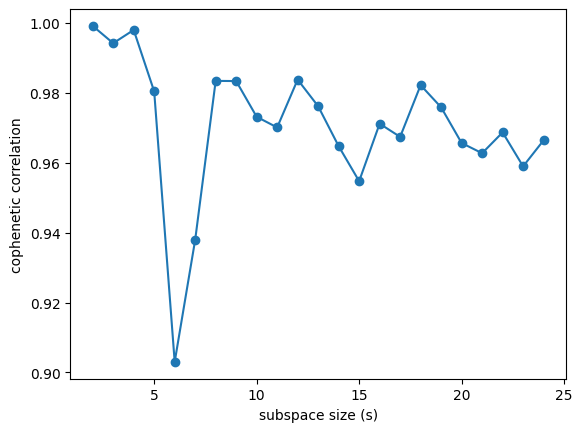

In [ ]:
coph_list = sio.loadmat("Coph_list_random.mat")["coph_list"]
plt.plot(list(range(2,25)), coph_list.T, "-o")
plt.xlabel("subspace size (s)")
plt.ylabel("cophenetic correlation")
plt.show()

# init = 'random'
# unreliable clustering for s = 6

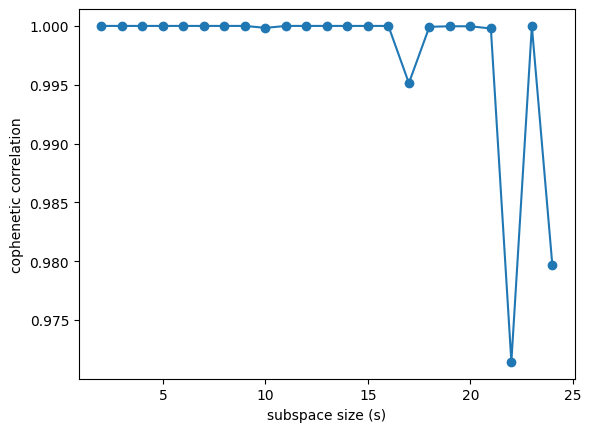

In [ ]:
coph_list = sio.loadmat("Coph_list.mat")["coph_list"]
plt.plot(list(range(2,25)), coph_list.T, "-o")
plt.xlabel("subspace size (s)")
plt.ylabel("cophenetic correlation")
plt.show()

# init=None
# unreliable clustering for s =

### Consensus, CPCC for H

In [ ]:
# Consensus clustering for H
M_H = consensusCluster(data=V, target="H", n_comp=s_opt, n_iter=250, name_mat="M_H_original", plot=True)

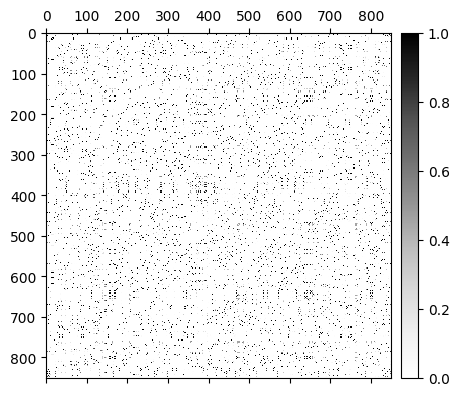

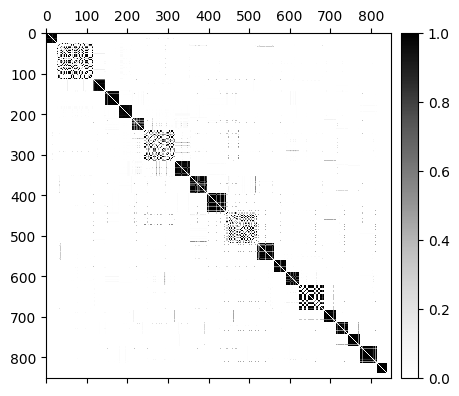

0.9821430648078394


In [12]:
M_H = sio.loadmat("M_H_original.mat", simplify_cells=True)["M"]
colorbar(plt.matshow(M_H, cmap="Greys"))
plt.show()

# average linkage HC
Z = linkage(y=1-M_H[np.triu_indices(850, k=1)],
            method='average', metric='euclidean', optimal_ordering=True)
#fig = plt.figure(figsize=(20, 10))
#dn = dendrogram(Z)
#plt.show()

HC_M_H = np.argsort(fcluster(Z, t=s_opt, criterion='maxclust'))
M_H_reord = M_H[HC_M_H][:,HC_M_H] # reordered consensus matrix according to HC
colorbar(plt.matshow(M_H_reord, cmap="Greys"))
plt.show()

# Cophenetic correlation coefficient
coph_W_H, _ = cophenet(Z, 1-M_H[np.triu_indices(V.shape[1], k=1)])
print(coph_W_H)


In [ ]:
# coph vs s
coph_H_list = list()

for s in range(2,25):
    C = consensusCluster(data=data, target="H", n_comp=s, n_iter=50, name_mat=None, plot=False)
    Z = linkage(y=1-C[np.triu_indices(data.shape[0], k=1)],
            method='average', metric='euclidean', optimal_ordering=False)
    coph_H, _ = cophenet(Z, 1-C[np.triu_indices(data.shape[0], k=1)])
    coph_H_list.append(coph_H)

sio.savemat("Coph_H_list.mat", dict(coph_H_list=coph_H_list))

In [ ]:
coph_H_list = sio.loadmat("Coph_H_list.mat")["coph_H_list"]
plt.plot(list(range(2,25)), coph_H_list.T, "-o")
plt.xlabel("subspace size (s)")
plt.ylabel("cophenetic correlation")
plt.show()

# unreliable clustering for s =

### Scrambling odor profiles

In [ ]:
# NMF on scrambled odor profiles
# 1: odorants: columns per row
V_rand_cols = np.copy(V)
# 2: descriptors: rows per column
V_rand_rows = np.copy(V)
# 3: 1 & 2
V_rand_compl = np.copy(V).flatten()

rng = np.random.default_rng()
rng.shuffle(V_rand_cols, axis=1)
rng.shuffle(V_rand_rows, axis=0)
rng.shuffle(V_rand_compl)
V_rand_compl = V_rand_compl.reshape(V.shape)

# NMF
config = dict(n_components=s_opt, init=None, solver='cd', beta_loss='frobenius', tol=0.0001,
            max_iter=200, random_state=None, alpha_W=0.01, alpha_H='same', l1_ratio=0.1,
            verbose=0, shuffle=False)

model_rand_cols = NMF(**config)
H_rand_cols = model_rand_cols.fit_transform(V_rand_cols.T).T
W_rand_cols = model_rand_cols.components_.T

model_rand_rows = NMF(**config)
H_rand_rows = model_rand_rows.fit_transform(V_rand_rows.T).T
W_rand_rows = model_rand_rows.components_.T

model_rand_compl = NMF(**config)
H_rand_compl = model_rand_compl.fit_transform(V_rand_compl.T).T
W_rand_compl = model_rand_compl.components_.T

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
M_rand_cols = sio.loadmat("M_rand_cols.mat")["M"]
M_rand_rows = sio.loadmat("M_rand_rows.mat")["M"]
M_rand_compl = sio.loadmat("M_rand_compl.mat")["M"]

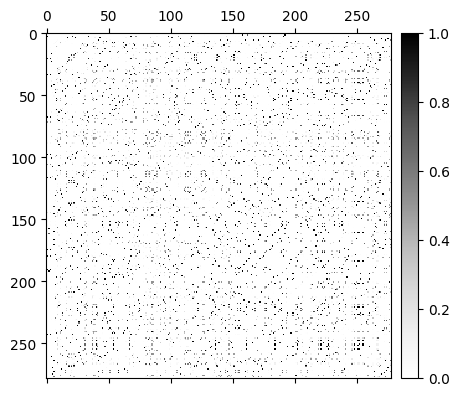

In [ ]:
# Consensus clustering (shuffled odorants)
M_rand_cols = consensusCluster(data=V_rand_cols, n_comp=s_opt, n_iter=250, name_mat="M_rand_cols", plot=True)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


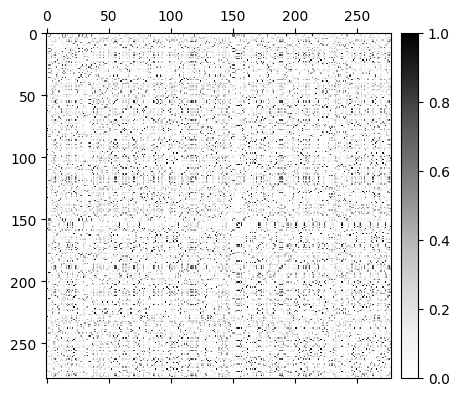

In [ ]:
# Consensus clustering (shuffled descriptors)
M_rand_rows = consensusCluster(data=V_rand_rows, n_comp=s_opt, n_iter=250, name_mat="M_rand_rows", plot=True)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

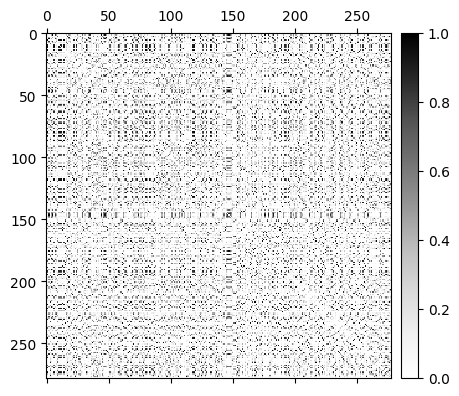

In [ ]:
# Consensus clustering (completely shuffled)
M_rand_compl = consensusCluster(data=V_rand_compl, n_comp=s_opt, n_iter=250, name_mat="M_rand_compl", plot=True)

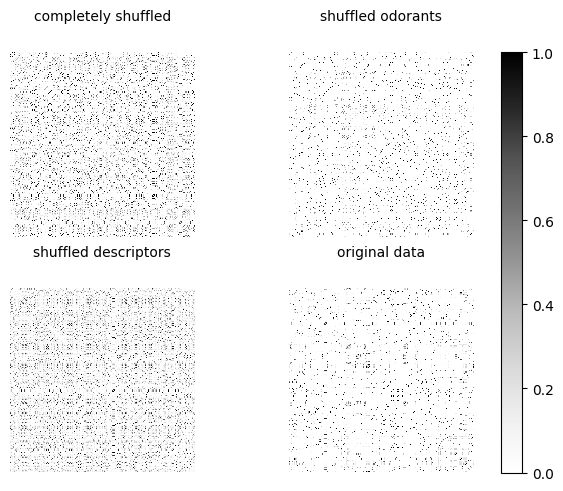

In [ ]:
# Consensus matrices for shuffled and original data
fig, axs = plt.subplots(2,2, layout="constrained")
matrices = [M_rand_compl, M_rand_cols, M_rand_rows, M]
titles = ["completely shuffled", "shuffled odorants", "shuffled descriptors", "original data"]
for (ax, mat, title) in zip(axs.flat, matrices, titles):
    im = ax.matshow(mat, cmap="Greys")
    ax.axis("off")
    ax.set_title(title, fontsize=10)
fig.colorbar(im, ax=axs)
plt.savefig("Consensus shuffled vs original.png")
plt.show()

# TO DO
# titles (position)

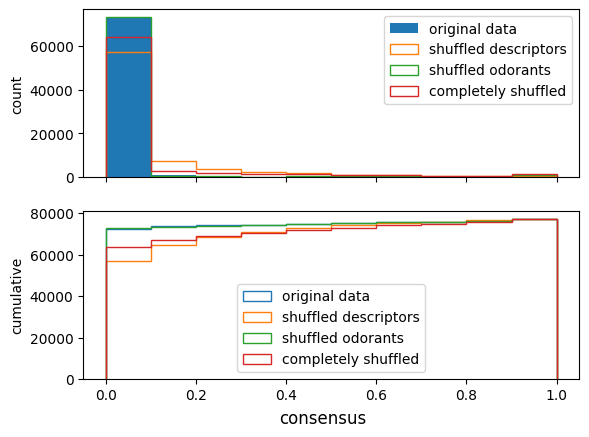

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.hist(M.flatten(), label="original data")
ax1.hist(M_rand_rows.flatten(), histtype="step", label="shuffled descriptors")
ax1.hist(M_rand_cols.flatten(), histtype="step", label="shuffled odorants")
ax1.hist(M_rand_compl.flatten(), histtype="step", label="completely shuffled")
ax1.set_ylabel("count")
ax1.legend()

ax2.hist(M.flatten(), cumulative=True, histtype="step", label="original data")
ax2.hist(M_rand_rows.flatten(), cumulative=True, histtype="step", label="shuffled descriptors")
ax2.hist(M_rand_cols.flatten(), cumulative=True, histtype="step", label="shuffled odorants")
ax2.hist(M_rand_compl.flatten(), cumulative=True, histtype="step", label="completely shuffled")
ax2.set_ylabel("cumulative")
ax2.legend()

fig.supxlabel("consensus")
#plt.tight_layout()

plt.show()

### Odor space visualization: t-SNE

<ipython-input-14-007f1136f491>:24: UserWarning: The palette list has more values (27) than needed (14), which may not be intended.
  ax = sns.scatterplot(x="tsne_1", y="tsne_2", data=W_embedded, hue="cluster", palette=cmap)


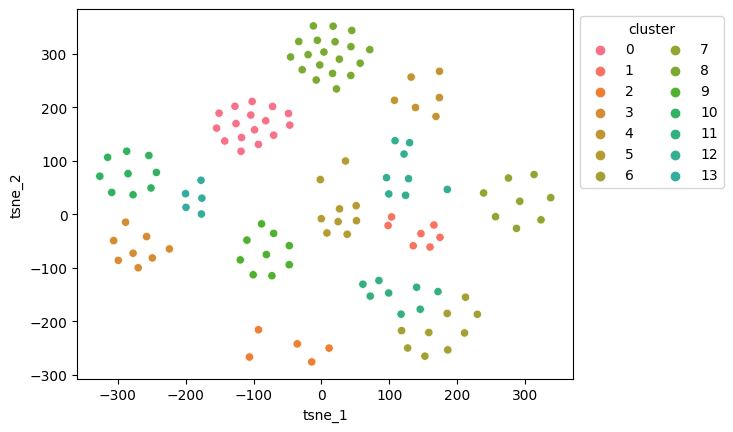

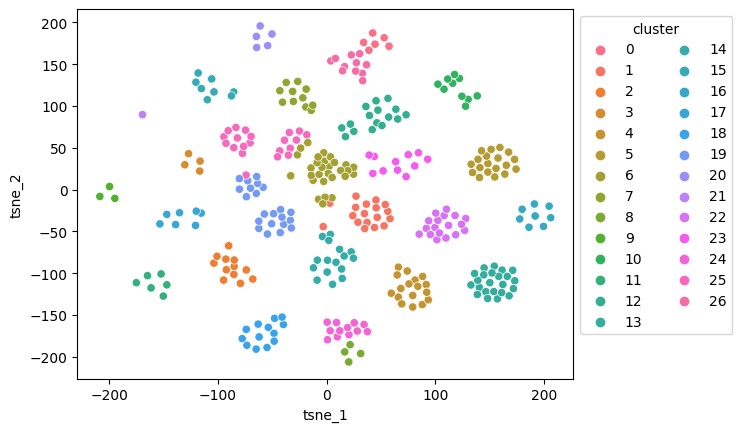

In [14]:
# Visualization (t-SNE: default parameters)
# columns -> W: odorkey_str[1:], H: gdb_name
config_tsne = dict(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate='auto',
              n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean',
              metric_params=None, init='pca', verbose=0, random_state=None, method='barnes_hut',
              angle=0.5, n_jobs=None)

config_kmeans_W = dict(n_clusters=14, init='k-means++', n_init='auto', max_iter=300,
                  tol=1e-4, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
config_kmeans_H = dict(n_clusters=27, init='k-means++', n_init='auto', max_iter=300,
                  tol=1e-4, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')

tsne_W = TSNE(**config_tsne).fit_transform(M)
kmeans_W = KMeans(**config_kmeans_W).fit(tsne_W)
W_embedded = pd.DataFrame({"tsne_1": tsne_W[:,0], "tsne_2": tsne_W[:,1], "cluster": kmeans_W.labels_})
W_embedded["cluster"] = W_embedded["cluster"].astype("category")

tsne_H = TSNE(**config_tsne).fit_transform(M_H)
kmeans_H = KMeans(**config_kmeans_H).fit(tsne_H)
H_embedded = pd.DataFrame({"tsne_1": tsne_H[:,0], "tsne_2": tsne_H[:,1], "cluster": kmeans_H.labels_})
H_embedded["cluster"] = H_embedded["cluster"].astype("category")

cmap = sns.color_palette("husl", 27)
ax = sns.scatterplot(x="tsne_1", y="tsne_2", data=W_embedded, hue="cluster", palette=cmap)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=2)
plt.show()

ax = sns.scatterplot(x="tsne_1", y="tsne_2", data=H_embedded, hue="cluster", palette=cmap)
ax.set_facecolor("none")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=2)
plt.show()

# TO DO
# kMeans parameters: n_clusters
# legend: ncol

In [15]:
def color_cols(data):
    df = pd.DataFrame().reindex_like(data)
    for i, col in enumerate(data):
        df[col] = "color: {}".format(cmap[i])
    return df

In [19]:
# table of corresponding descriptors or odorants
cmap = cmap.as_hex()
cluster_W = np.stack((kmeans_W.labels_, odorkey_str[1:]), axis=1)
cluster_H = np.stack((kmeans_H.labels_, gdb_name.astype("object")), axis=1)
descriptors = dict()
odorants = dict()

for i in range(14):
    descriptors["Cluster {}".format(i+1)] = list(cluster_W[cluster_W[:,0] == i,1])
for i in range(27):
    odorants["Cluster {}".format(i+1)] = list(cluster_H[cluster_H[:,0] == i,1])

max_len_descr = max(len(elem) for elem in descriptors.values())
for cluster in descriptors.values():
    cluster.extend(['']*(max_len_descr - len(cluster)))

max_len_odor = max(len(elem) for elem in odorants.values())
for cluster in odorants.values():
    cluster.extend(['']*(max_len_odor - len(cluster)))

descriptors = pd.DataFrame(descriptors)
descriptors.style.apply(color_cols, axis=None)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12,Cluster 13,Cluster 14
0,wine-like,citrus,balsamic,roasted,coconut,(balsam),fatty,pear,putrid,anise,butter,rancid,honey,strong
1,apple,orange,caramel,meaty,spicy,cherry,creamy,lime,pungent,fruity,chocolate,smoky,apricot,diffusive
2,banana,rose,cinnamon,burnt,pepper,grapefruit,oily,violet,cheese,berry,nutty,musty,carnation,burnt almond
3,pineapple,bread,sweet,coffee,mint,walnut,soapy,green,sour,grape,hazelnut,faint,hyacinth,green bell peppers
4,raspberry,mushroom,vanilla,sulfurous,geranium,floral,waxy,vegetable,garlic,jam,peanut,repulsive,iris,galbanum
5,ethereal,lemon peel,plum,egg,marigold,blossom,chemical,earthy,heavy,peach,popcorn,fishy,jonquil,wet
6,medicinal,weak,strawberry,cabbage,woody,hawthorne,melon,powerful,horseradish,quince,potato chip,cresylic,lily,
7,sage,buttermilk,almond,alliaceous,herbaceous,lilac,lemon,harsh,acid,gardenia,toasted grain,sharp,narcissus,
8,metallic,,caraway,onion,camphoraceous,mossy,penetrating,fresh,mustard,jasmine,bread crust,sweaty,mild,
9,phenolic,,fragrant,animal,leafy,(pungent),fennel,grassy,sickening,tart,cocoa,fecal,refreshing,


In [20]:
odorants = pd.DataFrame(odorants)
odorants.style.apply(color_cols, axis=None)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12,Cluster 13,Cluster 14,Cluster 15,Cluster 16,Cluster 17,Cluster 18,Cluster 19,Cluster 20,Cluster 21,Cluster 22,Cluster 23,Cluster 24,Cluster 25,Cluster 26,Cluster 27
0,Acetophenone,"3-Acetyl-2,5-dimethylfuran",Acetaldehyde,2-Acetyl-3-ethylpyrazine,2-sec-Butylcyclohexanone,Dibenzyl ether,Acetovanillone,Butyl anthranilate,Allyl trans-2-methyl-2-butenoate,Amyl acetate,Acetaldehyde diethyl acetal,Acetone,Benzyl tiglate,Benzyl disulfide,n-Butyl Stearate,acetaldehyde phenethyl propyl acetal,Allyl nonanoate,Allyl cyclohexane propionate,Allyl cinnamate,"2-Acetyl-3,5(or 6)-dimethylprazine",2-Acetylpyridine,Adipic acid,Acetanisole,Estragole,a-Amylcinnamaldehyde dimethyl acetal,2-Acetylthiazole,Anisyl alcohol
1,p-Methoxybenzaldehyde,a-Amylcinnamaldehyde,Allyl isothiocyanate,2-Acetyl-5-methylfuran,4-tert-Butylcyclohexyl acetate,"1,4-Cineole",4-(p-Acetoxyphenyl)-2-butanone,Citral diethyl acetal,a-Amylcinnamyl acetate,Amyl formate,Allyl 2-furoate,Benzyl isovalerate,n-Butyl phenylacetate,4-Carvomenthenol,Cyclohexanecarboxylic acid,n-Butyl heptanoate,Amyl octanoate,Allyl hexanoate,n-Amyl alcohol,"3-Acetyl-2,5-dimethylthiophene",Allyl 2-ethylbutyrate,dl-Alanine,Acetoin,Allyl heptylate,Citral dimethyl acetal,Benzoin,Benzyl propionate
2,Anisyl propionate,Citral,Allyl sulfide,Acetylpyrazine,Butyrophenone,Cinnamaldehyde,(-)-Ambroxide,Diethyl maleate,(-)-Carvyl acetate,Anisole,Benzyl isobutyrate,n-Butyl isobutyrate,Citronellyl acetate,o-Cresol,Cyclohexyl acetate,3-butylidenephthalide,Benzenethiol,Allyl octanoate,o-Anisaldehyde,2-Acetyl-3-methylpyrazine,Amyl 2-furoate,Caffeine,2-Acetoxy-3-Butanone,Allyl phenylacetate,B-Cyclocitral,Butanol,Cinnamic acid
3,Benzophenone,Cyclohexaneethyl acetate,4-Phenyl-3-buten-2-ol,3-Acetylpyridine,d-Camphene,Cinnamyl isovalerate,Ammonium sulfide,"2,6-Dimethyl-5-heptenal",Dicyclohexyl disulfide,Methyl Ethyl Ketone,Butan-3-one-2-yl- butyrate,n-Butyl isovalerate,Citronellyl butyrate,m-Dimethoxybenzene,Decanoic acid,Butyl sulfide,n-Butyl hexanoate,Allyl phenoxyacetate,Anisyl formate,"4-Allyl-2,6-dimethoxyphenol",a-Angelica lactone,Citric acid,Allyl butyrate,Allyl Thiopropionate,Dimethyl disulfide,Butyl 2-methylbutyrate,Citronellyl formate
4,Benzyl Acetate,"2-trans, 4-trans-Decadienal",Biphenyl,6-amyl-a-pyrone,dextro-Camphor,Cinnamyl propionate,a-Amylcinnamyl alchol,Ethyl myristate,diphenyl ether,n-Butyl Formate,n-Butyl-n-butyrate,n-Butyl Valerate,Citronellyl isobutyrate,"2,6-dimethylthiophenol",3-Decanone,I-Carveol,Diethyl sebacate,Allyl propionate,Benzoic Acid,Allyl disulfide,n-Butyl laurate,3-Ethyl-2-hydroxy-2-cyclopenten-1-one,Buyl butyrylactate,Benzaldehyde,"2,4-hexadienal",meta-Cresol,Decanal
5,Benzyl acetoacetate,3-Decen-2-one,1-butanethiol,Benzaldehyde dimethyl acetal,b-Caryophyllene,"2,4-dimethylbenzaldehyde",p-Anisic acid,Ethyl palmitate,Ethyl (+/-)-2-hydroxycaproate,n-Butyl Propionate,Butyl levulinate,Cyclohexyl butyrate,Citronellyl propionate,2-ethylfenchol,trans-2-Decenal,l-Carvone,Diethyl L-tartrate,Amyl butyrate,Benzyl Benzoate,Allyl a-ionone,p-Dimethoxybenzene,Furfuryl alcohol,d-Decalactone,n-Butyl lactate,"trans,trans-2,4-Hexadien-1-ol",Dihydrocarveol,Geraniol
6,Benzyl butyrate,Diacetyl,Butylamine,"2,3-diethyl-5-methylpyrazine",Dihydrocoumarin,p-Ethoxybenzaldehyde,Anisyl acetate,Ethyl stearate,Ethyl 2-nonynoate,Decyl propionate,t-Decalactone,Ethyl valerate,Citronellyl tiglate,Ethyl 2-mercaptopropionate,Decyl butyrate,d-Dihydrocarvone,Dimethyl anthranilate,Amyl hexanoate,Benzyl cinnamate,Allyl mercaptan,2-Ethylbutyl acetate,2-Furoic acid,d-Dodecalactone,Carvacrol,trans-3-Hexen-1-ol,Dihydrocarvyl acetate,2'-hydroxyacetophenone
7,Decanol,"2,6-dimethyl-4-heptanone",n-Butyric Acid,"2,3-diethylpyrazine","3',4'-Dimethoxyacetophenone",1-ethylhexyl tiglate,Benzothiazole,1-Hexadecanol,Ethyl 3-oxohexanoate,Ethyl acetoacetate,Diethyl malate,Geranyl butyrate,Citronellyl valerate,1-furfurylpyrrole

In [ ]:
# TO DO
# styler.to_latex()

### PCA

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


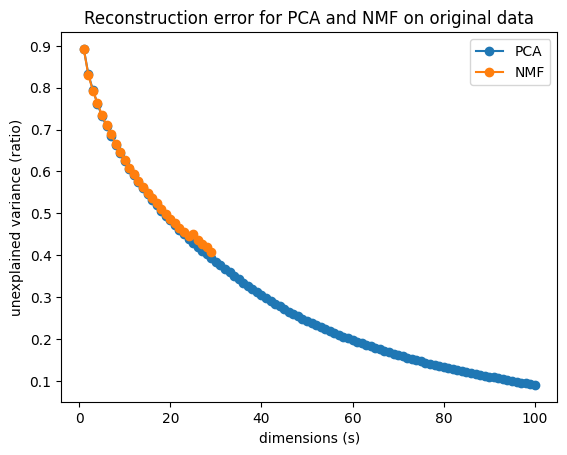

In [ ]:
# PCA (original data)
unexpl_var_NMF = list()
for s in range(1,30):
    model = NMF(n_components=s, init=None, solver='cd', beta_loss='frobenius',
                tol=1e-4, max_iter=200, random_state=None, alpha_W=0.01, alpha_H='same',
                l1_ratio=0.1, verbose=0, shuffle=False)
    H = model.fit_transform(X=V.T).T
    W = model.components_.T
    unexpl_var_NMF.append(1-explained_variance_score(V, W@H)) # similar to 1 - R^2

unexpl_var_PCA = list()
for s in range(1,101):
    model = PCA(n_components=s, copy=True, whiten=False, svd_solver='auto',
                tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto',
                random_state=None)
    model.fit_transform(V)
    unexpl_var_PCA.append(1-np.sum(model.explained_variance_ratio_))

plt.plot(list(range(1,101)), unexpl_var_PCA, "-o", label="PCA")
plt.plot(list(range(1,30)), unexpl_var_NMF, "-o", label="NMF")
plt.title("Reconstruction error for PCA and NMF on original data")
plt.xlabel("dimensions (s)")
plt.ylabel("unexplained variance (ratio)")
plt.legend()
plt.show()

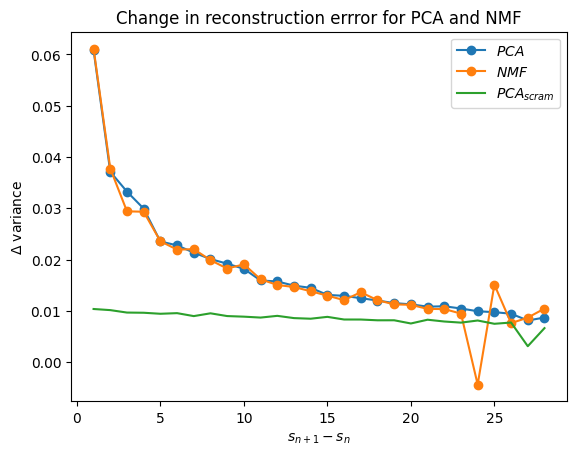

In [ ]:
# PCA (scrambled data)
unexpl_var_PCA_scram = list()

for s in range(1,30):
    model = PCA(n_components=s, copy=True, whiten=False, svd_solver='auto',
                tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto',
                random_state=None)
    model.fit(V_rand_compl)     # shuffled descriptors & odors
    unexpl_var_PCA_scram.append(1-np.sum(model.explained_variance_ratio_))

plt.plot(list(range(1,29)), [unexpl_var_PCA[i-1] - unexpl_var_PCA[i] for i in range(1,29)], "-o", label="$PCA$")
plt.plot(list(range(1,29)), [unexpl_var_NMF[i-1] - unexpl_var_NMF[i] for i in range(1,29)], "-o", label="$NMF$")
plt.plot(list(range(1,29)), [unexpl_var_PCA_scram[i-1] - unexpl_var_PCA_scram[i] for i in range(1,29)], label="$PCA_{scram}$")
plt.title("Change in reconstruction errror for PCA and NMF")
plt.xlabel("$s_{n+1} - s_n$")
plt.ylabel("$\Delta$ variance")
plt.legend()
plt.show()

In [ ]:
# 10-dim NMF
s_opt = 10

"""model = NMF(n_components=s_opt, init='random', solver='cd', beta_loss='frobenius',
            tol=0.0001, max_iter=1000, random_state=None, alpha_W=0.01, alpha_H='same',
            l1_ratio=0.1, verbose=0, shuffle=False)
H10 = model.fit_transform(X=V.T).T # sklearn: exchange of W & H
W10 = model.components_.T"""

W10 = kl_divergence(V, target="W", n_comp=s_opt, n_iter=250)
H10 = kl_divergence(V, target="H", n_comp=s_opt, n_iter=250)

In [ ]:
W10 = sio.loadmat("W10.mat")["W_opt"]
H10 = sio.loadmat("H10.mat")["W_opt"]

### Properties of W

In [ ]:
W_opt = W10
H_opt = H10

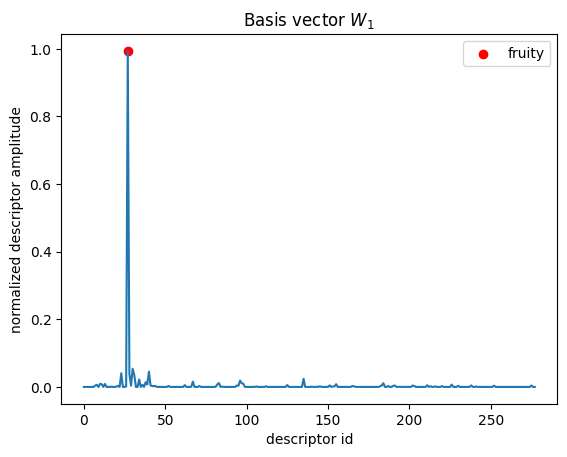

In [ ]:
W_normal = normalize(W_opt, axis=0) # normalized basis vectors
#print(np.linalg.norm(W_normal[:,0]))

plt.title("Basis vector $W_1$")
plt.xlabel("descriptor id")
plt.ylabel("normalized descriptor amplitude")
plt.plot(list(range(278)), W_normal[:,0])
plt.scatter(np.argmax(W_normal[:,0]), W_normal[np.argmax(W_normal[:,0]),0],
            c='r', label=odorkey_str[np.argmax(W_normal[:,0])+1])
plt.legend()
plt.show()

# argmax = 27 -> fruity
#print(np.argmax(W_normal[:,0]))
#print(odorkey_str[28]) # kept indices -> 27+1

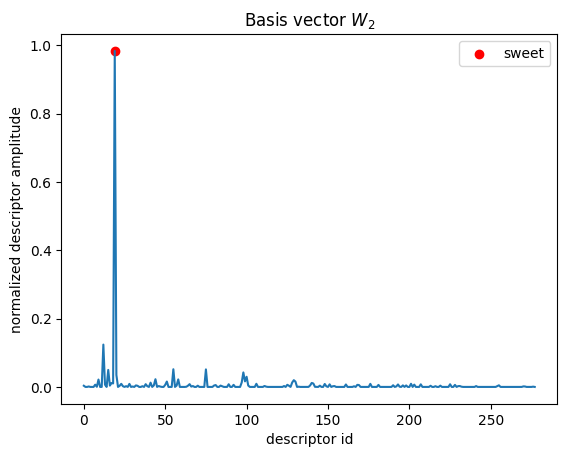

In [ ]:
plt.title("Basis vector $W_2$")
plt.xlabel("descriptor id")
plt.ylabel("normalized descriptor amplitude")
plt.plot(list(range(278)), W_normal[:,1])
plt.scatter(np.argmax(W_normal[:,1]), W_normal[np.argmax(W_normal[:,1]),1],
            c='r', label=odorkey_str[np.argmax(W_normal[:,1])+1])
plt.legend()
plt.show()

# argmax = 19 -> sweet
#print(np.argmax(W_normal[:,1]))
#print(odorkey_str[20]) # kept indices -> 19+1

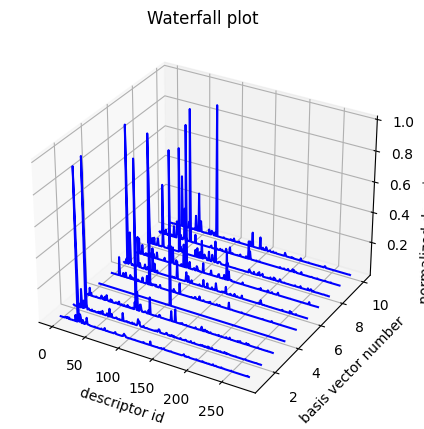

In [ ]:
# Waterfall (original data)
ax = plt.figure(figsize=(20,5)).add_subplot(projection='3d')

for i in range(10):
    ax.plot(list(range(278)), W_normal[:,i], zs=i+1, zdir='y', color='b')

ax.set_title('Waterfall plot')
ax.set_xlabel('descriptor id')
ax.set_ylabel('basis vector number')
ax.set_zlabel('normalized descriptor amplitude')
plt.savefig("waterfall.png")
plt.show()

# TO DO
# cut off y-label

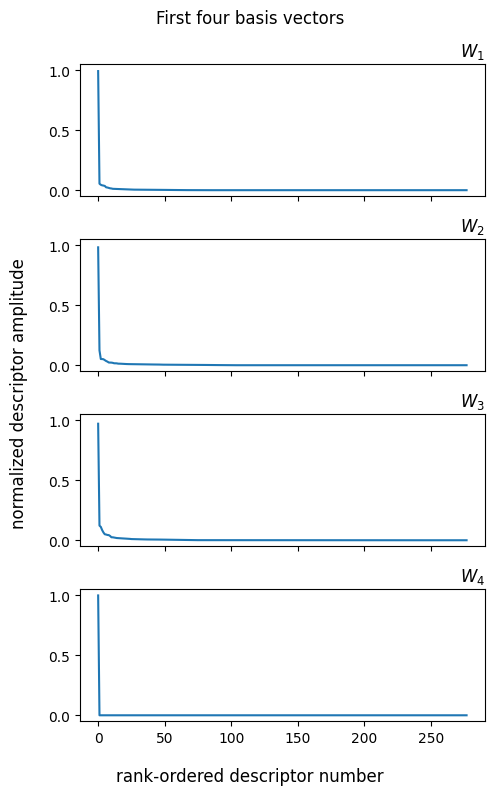

In [ ]:
# rank-ordered descriptor amplitudes
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(5,8))

for i, ax in enumerate(axs.flat):
    ax.plot(list(range(278)), sorted(W_normal[:,i], reverse=True))
    ax.set_title("$W_{}$".format(i+1), loc='right')

fig.suptitle("First four basis vectors")
fig.supxlabel("rank-ordered descriptor number")
fig.supylabel("normalized descriptor amplitude")
fig.tight_layout()
plt.show()

# TO DO
# scaling axis

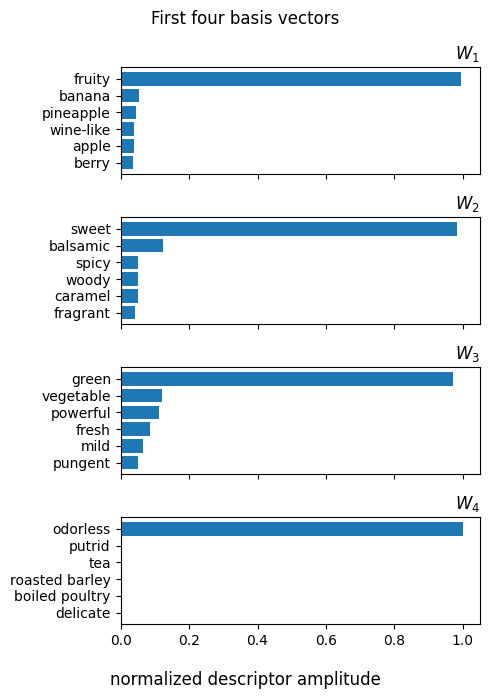

In [ ]:
# semantic descriptors of the first six rank-ordered components
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(5,7))

for i, ax in enumerate(axs.flat):
    descriptors_key = np.argsort(-W_normal[:,i])[:6] # 1st six rank-ordered descriptor ids
    descriptors_str = odorkey_str[descriptors_key+1]
    ax.barh(descriptors_str, W_normal[descriptors_key,i])
    ax.set_title("$W_{}$".format(i+1), loc='right')
    #ax.tick_params(axis="y", labelsize=10)
    ax.invert_yaxis()

fig.suptitle("First four basis vectors")
fig.supxlabel("normalized descriptor amplitude")
plt.tight_layout()
plt.show()

In [ ]:
# table of 10 largest-valued descriptors
W10_dict = dict()
for i in range(10):
    W10_dict["W{}".format(i+1)] = odorkey_str[np.argsort(-W_normal[:,i])+1][:10]
W10_dict = pd.DataFrame(W10_dict)

W10_dict

,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10
0,fruity,sweet,green,odorless,floral,fatty,herbaceous,nutty,ethereal,rose
1,banana,balsamic,vegetable,putrid,balsamic,oily,warm,meaty,pungent,honey
2,pineapple,spicy,powerful,tea,heavy,waxy,woody,roasted,pineapple,citrus
3,wine-like,woody,fresh,roasted barley,spicy,citrus,spicy,coffee,rum,pineapple
4,apple,caramel,mild,boiled poultry,delicate,musty,mint,cocoa,apple,mild
5,berry,fragrant,pungent,delicate,orange,powerful,pungent,sulfurous,banana,warm
6,fresh,vanilla,violet,magnolia,waxy,orange,oily,burnt,wine-like,orange
7,grape,faint,musty,plastic,apricot,creamy,heavy,vegetable,medicinal,apricot
8,strong,strawberry,earthy,seedy,honey,sharp,spearmint,strong,sharp,waxy
9,jasmine,mint,berry,light,fresh,penetrating,camphoraceous,chocolate,phenolic,carnation


### Structure of H

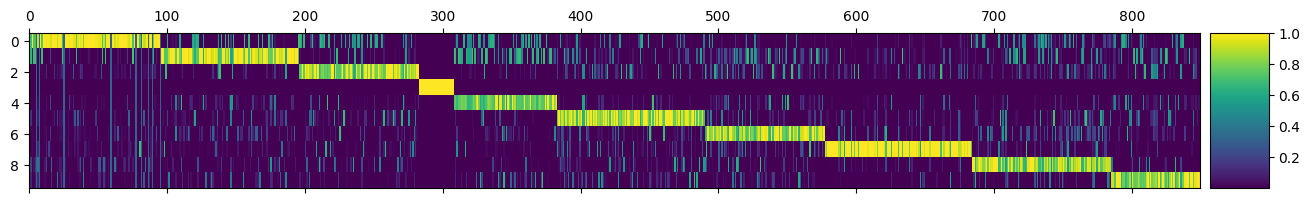

In [ ]:
H_normal = normalize(H_opt, axis=0) # normalized weights (cols)

group_id = [j for i in range(s_opt) for j in range(850) if np.argmax(H_normal[:,j]) == i]
H_opt_reord = H_normal[:,group_id]

colorbar(plt.matshow(H_opt_reord, aspect="auto"))
plt.show()

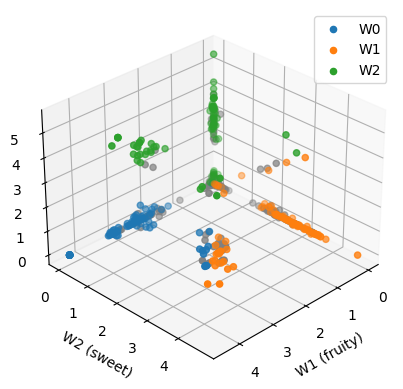

In [ ]:
# Odors in space spanned by first three basis vectors
# indices of odors with peak values in W1, W2 or W3
H_peaks = [[j for j in range(850) if np.argmax(H_opt[:,j]) == i] for i in range(3)]
H_peaks_flat = [item for sublist in H_peaks for item in sublist]
# remaining indices
H_remain = [i for i in range(850) if i not in H_peaks_flat]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(3):
    ax.scatter(H_opt[0,H_peaks[i]], H_opt[1,H_peaks[i]], H_opt[2,H_peaks[i]], label="W{}".format(i))
ax.scatter(H_opt[0,H_remain], H_opt[1,H_remain], H_opt[2,H_remain], color="grey")
ax.set_xlabel('W1 ({})'.format(odorkey_str[np.argsort(-W_normal[:,0])+1][0]))
ax.set_ylabel('W2 ({})'.format(odorkey_str[np.argsort(-W_normal[:,1])+1][0]))
ax.set_zlabel('W3 ({})'.format(odorkey_str[np.argsort(-W_normal[:,2])+1][0]))
ax.view_init(elev=30, azim=45, roll=0)
plt.legend()
plt.savefig("odors 3D.png")
plt.show()


### Bi-clustering

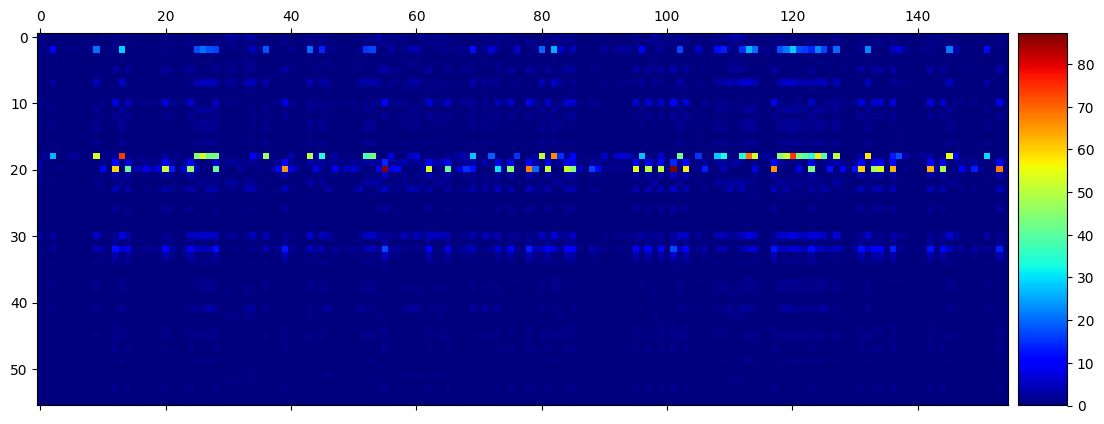

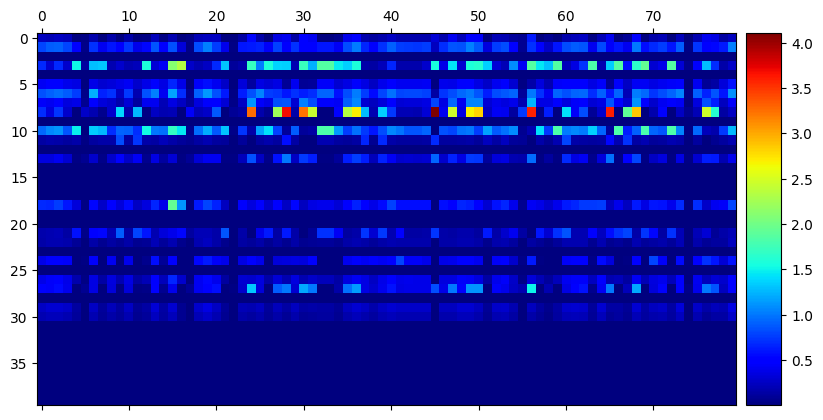

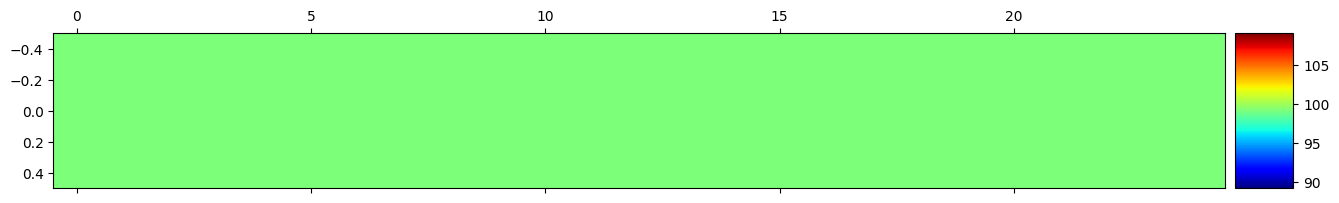

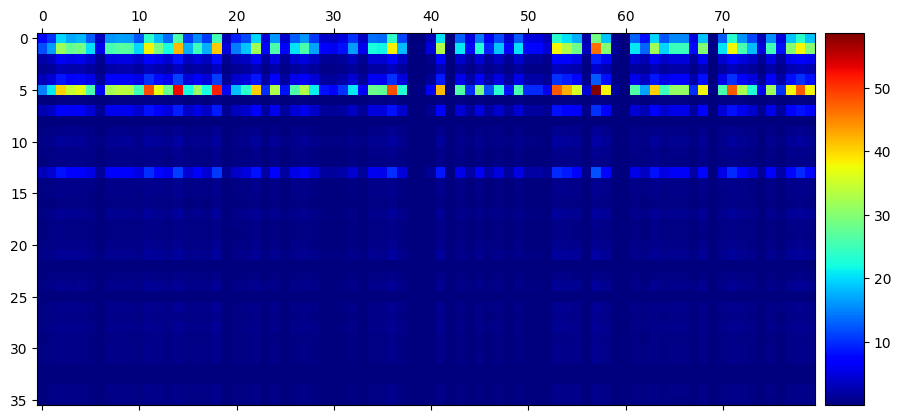

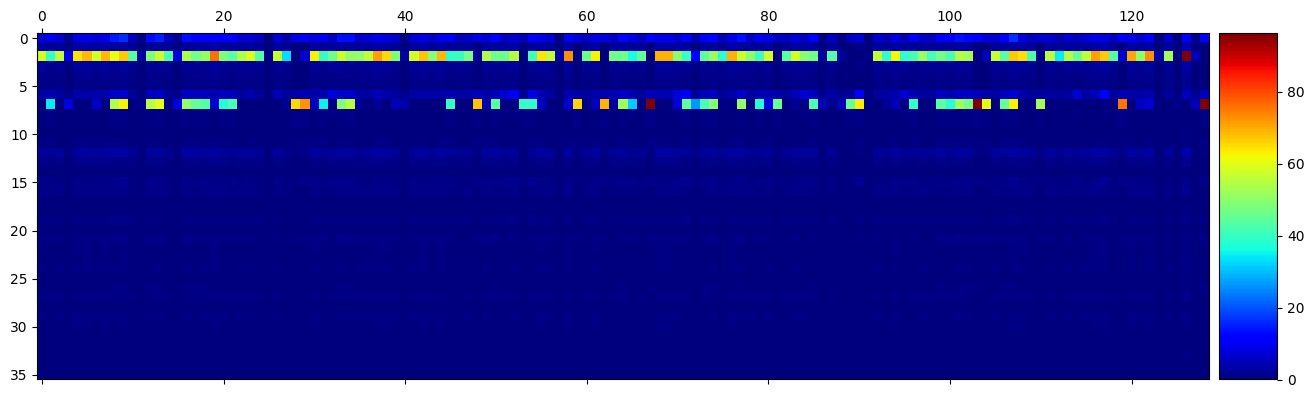

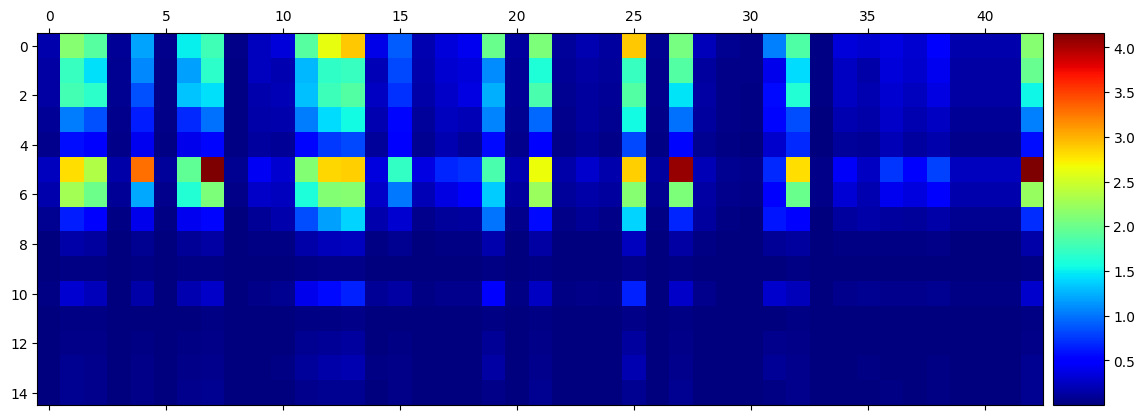

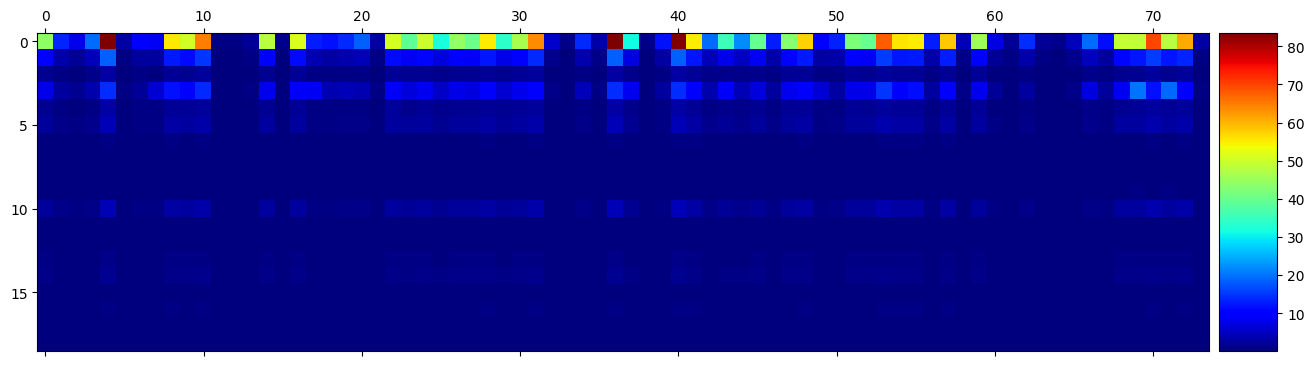

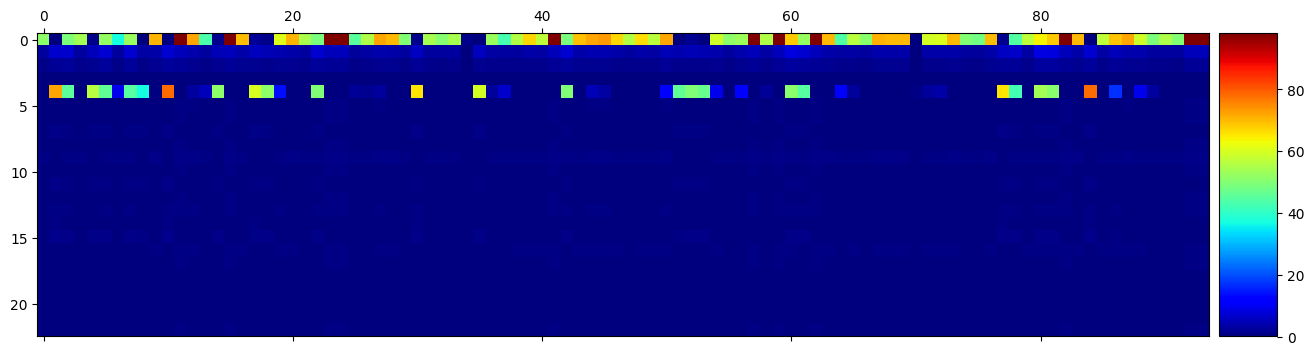

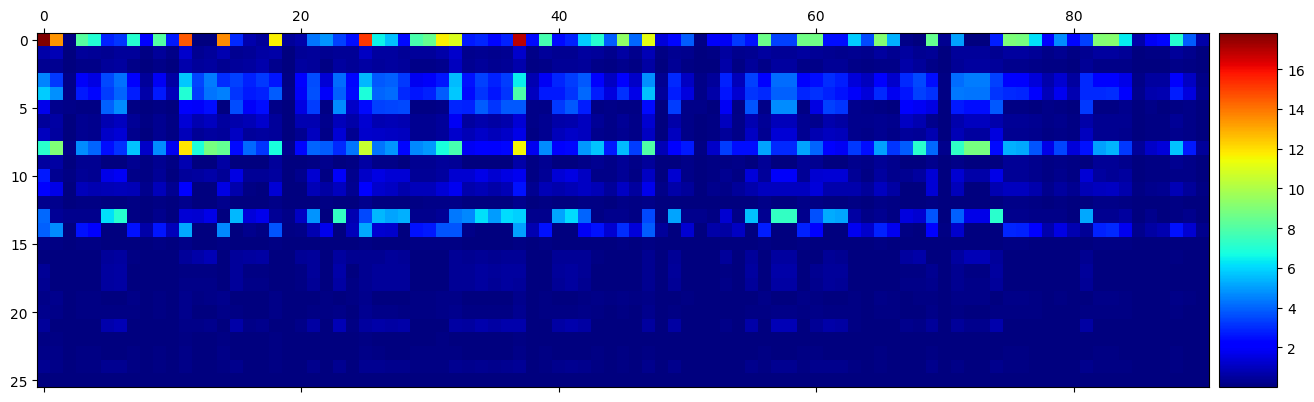

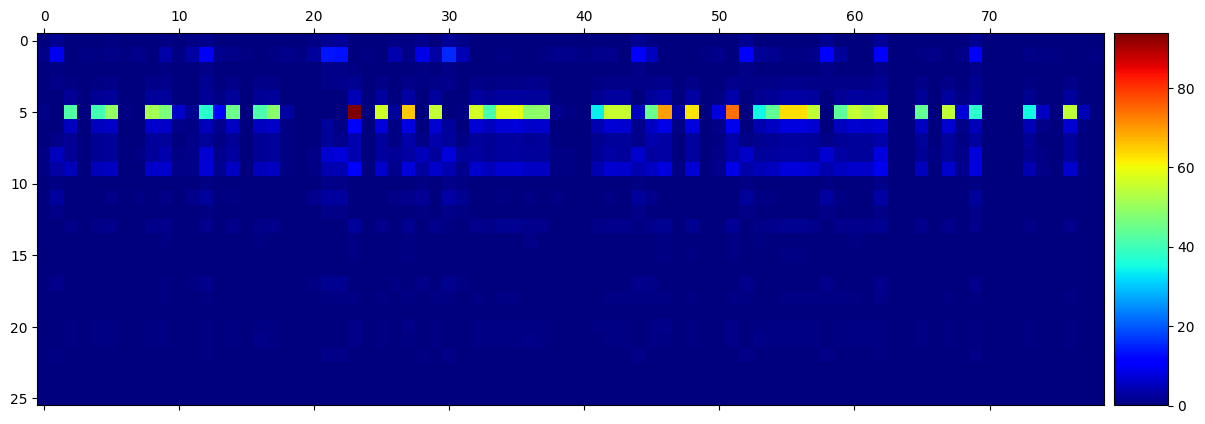

In [ ]:
WH = W_opt@H_opt
WH[WH == 0] = 1e-8
WH_cluster = SpectralCoclustering(n_clusters=10, svd_method='randomized', n_svd_vecs=None, mini_batch=False,
                     init='k-means++', n_init=10, random_state=None)

WH_cluster.fit(WH)

for i in range(10):
    colorbar(plt.matshow(WH_cluster.get_submatrix(i, WH), cmap="jet", aspect="auto"))
    plt.show()

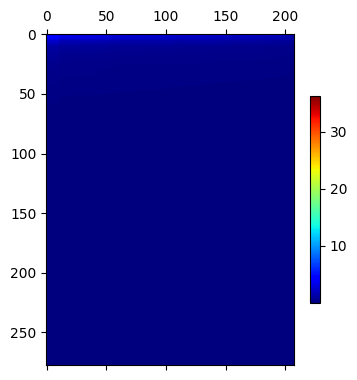

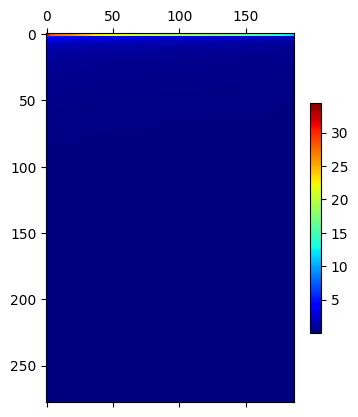

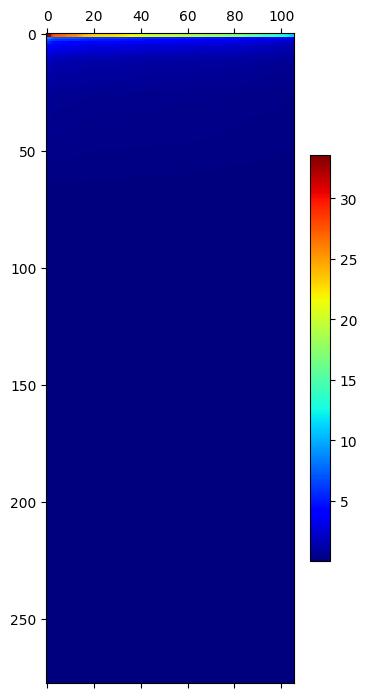

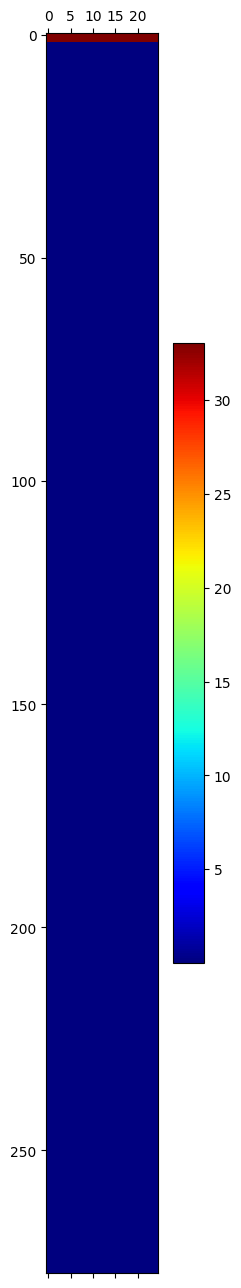

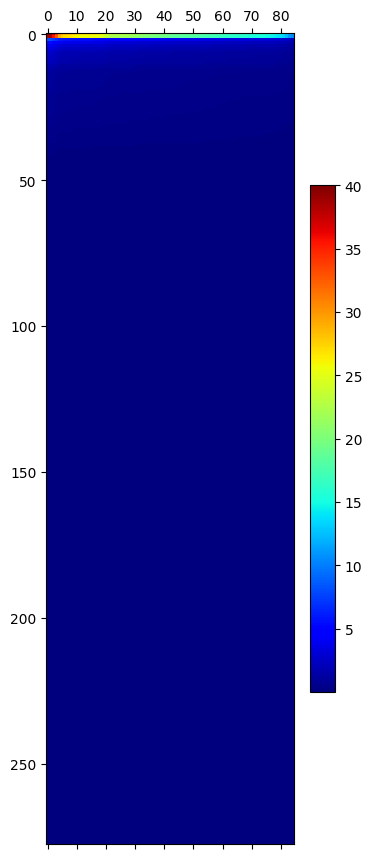

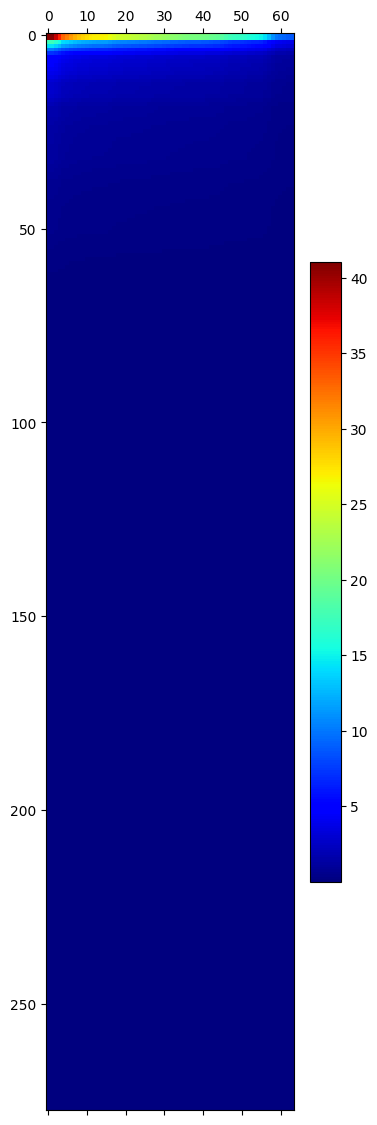

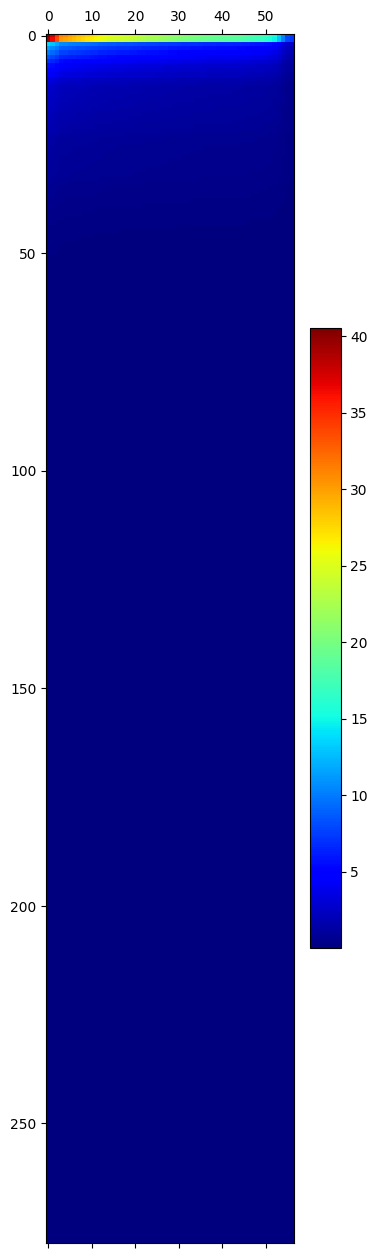

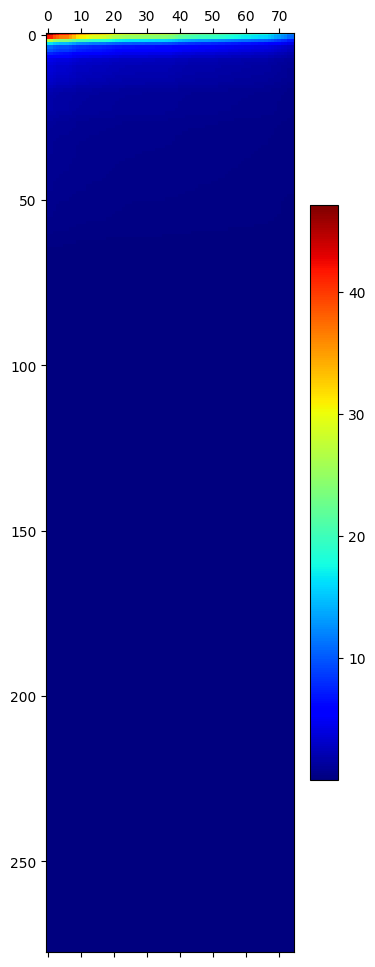

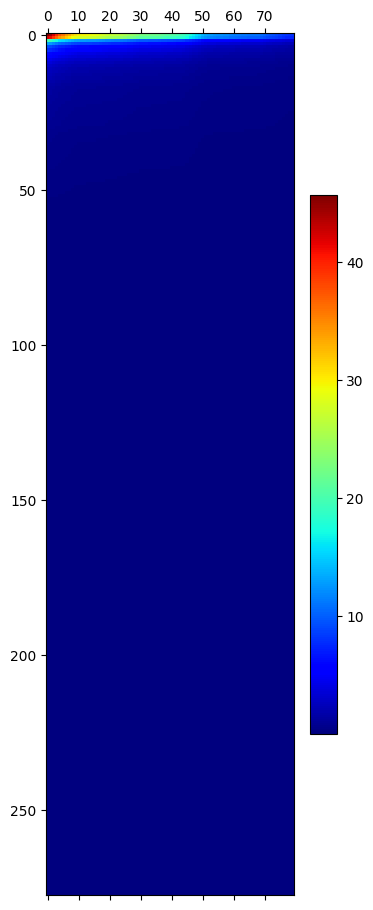

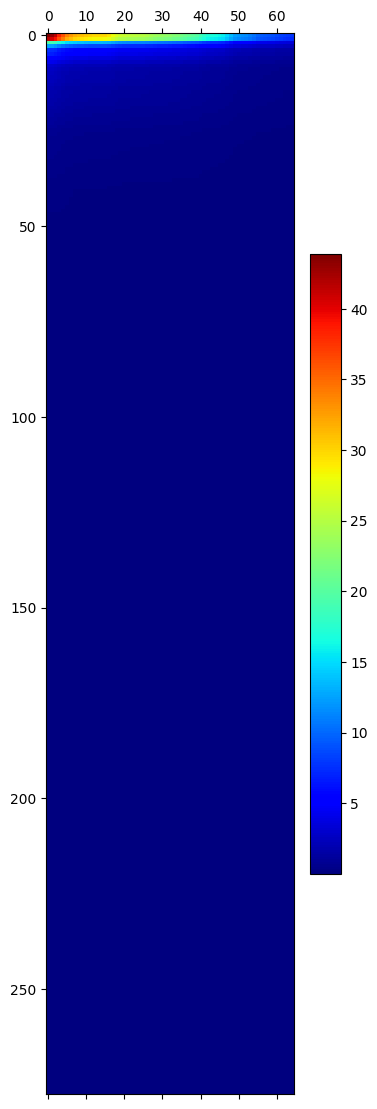

In [ ]:
for i in range(10):
    rows = -np.sort(-W10[:,i])
    rows = rows[rows > 0] # TO DO: limit
    cols = -np.sort(-H10[i,:])
    cols = cols[cols > 1] # TO DO: limit
    mat = np.outer(rows, cols)
    blur = cv2.blur(mat,(3,3)) # 3x3 averaging filter
    plt.colorbar(plt.matshow(blur, cmap="jet", aspect=1), shrink=0.5)
    plt.show()

### Shuffled data

In [ ]:
# normalized basis vectors
W_normal_cols = normalize(W_rand_cols, axis=0)
W_normal_rows = normalize(W_rand_rows, axis=0)
W_normal_compl = normalize(W_rand_compl, axis=0)

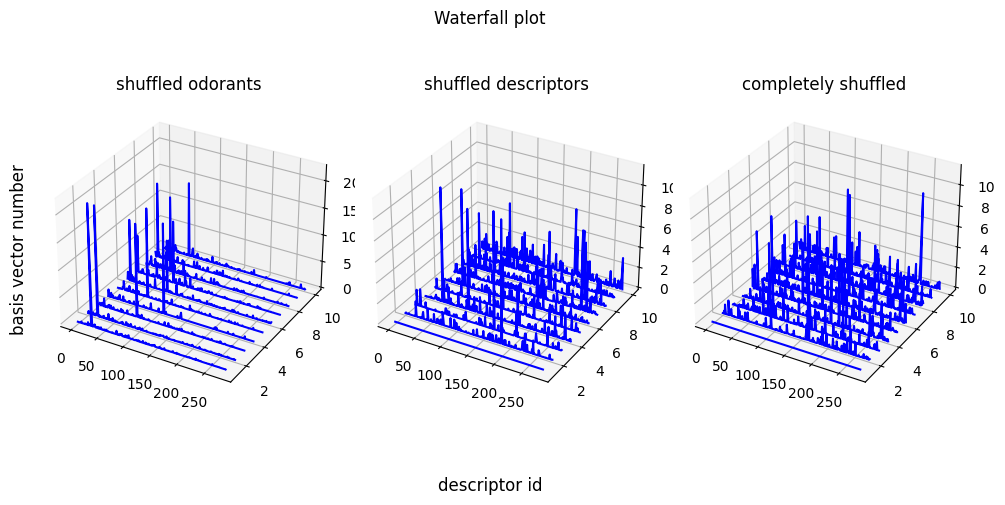

In [ ]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.set_title('shuffled odorants')
ax2 = fig.add_subplot(132, projection='3d')
ax2.set_title('shuffled descriptors')
ax3 = fig.add_subplot(133, projection='3d')
ax3.set_title('completely shuffled')

for i in range(10):
    ax1.plot(list(range(278)), W_rand_cols[:,i], zs=i+1, zdir='y', color='b')
    ax2.plot(list(range(278)), W_rand_rows[:,i], zs=i+1, zdir='y', color='b')
    ax3.plot(list(range(278)), W_rand_compl[:,i], zs=i+1, zdir='y', color='b')

fig.suptitle('Waterfall plot')
fig.supxlabel('descriptor id')
fig.supylabel('basis vector number')
#fig.supzlabel('normalized descriptor amplitude')

plt.tight_layout()
plt.show()

# TO DO
# axis label

#### separate waterfall plots

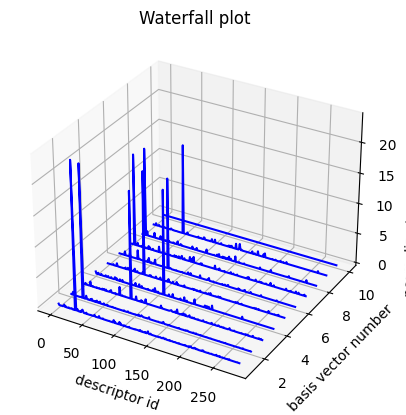

In [ ]:
# Waterfall plot (shuffled odorants)
ax = plt.figure().add_subplot(projection='3d')

for i in range(10):
    ax.plot(list(range(278)), W_rand_cols[:,i], zs=i+1, zdir='y', color='b')

ax.set_title('Waterfall plot')
ax.set_xlabel('descriptor id')
ax.set_ylabel('basis vector number')
ax.set_zlabel('normalized descriptor amplitude')
plt.show()

# TO DO
# cut off y-label

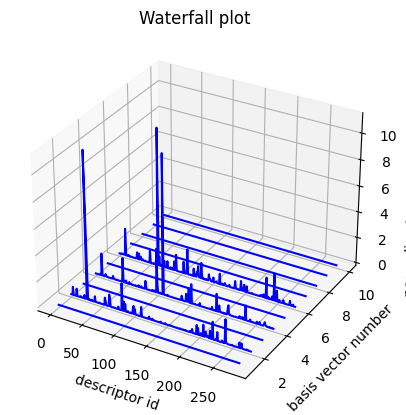

In [ ]:
# Waterfall plot (shuffled descriptors)
ax = plt.figure().add_subplot(projection='3d')

for i in range(10):
    ax.plot(list(range(278)), W_rand_rows[:,i], zs=i+1, zdir='y', color='b')

ax.set_title('Waterfall plot')
ax.set_xlabel('descriptor id')
ax.set_ylabel('basis vector number')
ax.set_zlabel('normalized descriptor amplitude')
plt.show()

# TO DO
# cut off y-label

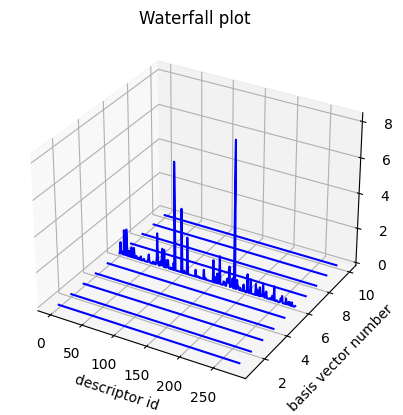

In [ ]:
# Waterfall plot (completely shuffled)
ax = plt.figure().add_subplot(projection='3d')

for i in range(10):
    ax.plot(list(range(278)), W_rand_compl[:,i], zs=i+1, zdir='y', color='b')

ax.set_title('Waterfall plot')
ax.set_xlabel('descriptor id')
ax.set_ylabel('basis vector number')
ax.set_zlabel('normalized descriptor amplitude')
plt.show()

# TO DO
# cut off y-label

### Orthogonality of basis vectors

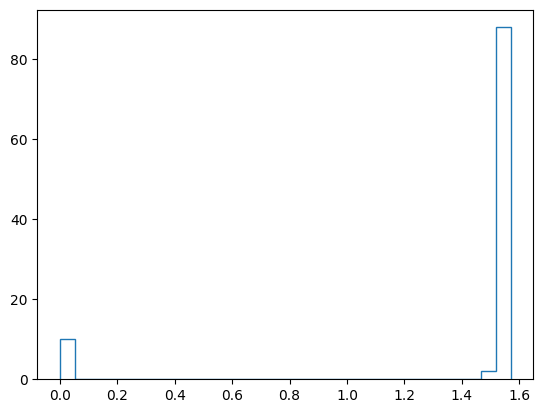

In [ ]:
# bar plot
WTW = W_normal.T@W_normal
WTW[WTW > 1] = 1 # round-off error
angles = np.arccos(WTW)
angles = np.ma.array(angles, mask=np.tri(angles.shape[0], k=0)) # masked tril
#print(np.round(angles, 2))
plt.stairs(*np.histogram(angles, bins=30, range=(0,np.pi/2)))
plt.show()

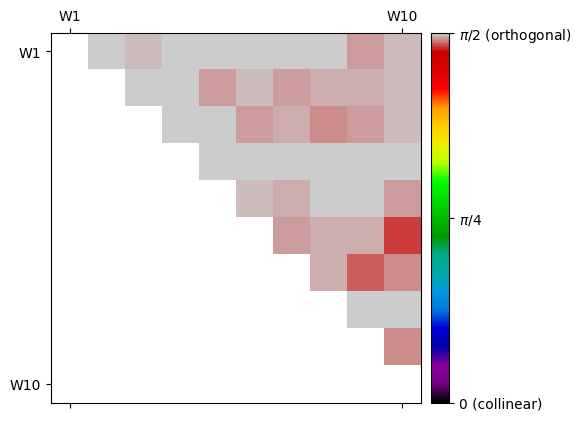

In [ ]:
cmap = plt.colormaps.get_cmap("nipy_spectral")
cmap.set_bad("w")

fig, ax = plt.subplots()
mat = ax.matshow(angles, cmap=cmap, vmin=0, vmax=np.pi/2)
ax.set_xticks(ticks=[0,9], labels=["W1", "W10"])
ax.set_yticks(ticks=[0,9], labels=["W1", "W10"])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(mat, cax=cax)
cbar.set_ticks(ticks=[0, np.pi/4, np.pi/2], labels=["0 (collinear)", "$\pi/4$", "$\pi/2$ (orthogonal)"])
plt.show()

## Supporting figures

In [ ]:
WH = W_opt@H_opt

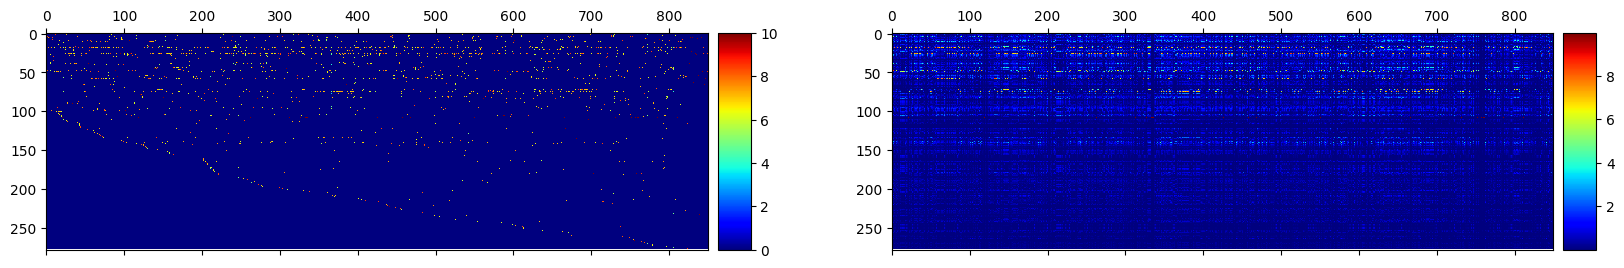

In [ ]:
V_corrected = exposure.adjust_gamma(V, gamma=0.5, gain=1)
WH_corrected = exposure.adjust_gamma(WH, gamma=0.5, gain=1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
colorbar(ax1.matshow(V_corrected, cmap="jet"))
colorbar(ax2.matshow(WH_corrected, cmap="jet"))

plt.show()